<a href="https://colab.research.google.com/github/jpvoelz/emotion-classification/blob/main/GoEmotions_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilabel Emotion Classification

## Antonia George, Lenka Sefcakova & Joule Voelz

In this project, we we test three different approaches for multi-label emotion classification using the GoEmotions dataset: a One-vs-Rest logistic regression classifier, an RNN classifier, and a classifier based on BERT. With the BERT model, we successfully replicate the SoA result of the original Demszky et al. (2020) paper.

# Evaluation metrics

We evaluate our classifiers based on precision, recall, and F1-score for each emotion label and as a macro-average.

Precision measures what ratio of predicted labels are accurate. Recall measures how many of the ground truth labels are predicted. The F1-score is the harmonic mean of precision and recall. The macro-average measures the unweighted mean of metrics for each label.

The SOA macro-average metrics for this task (from Demszky et al) are 0.40 precision, 0.63 recall, and 0.46 F1-score.

# Imports

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import warnings
import random
from scipy import interp

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install datasets transformers
!pip install tensorflow_ranking
!pip install datasets transformers sentence_transformers umap-learn

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
import spacy

%cd /content/gdrive/MyDrive/go_emotions
from nlp_helper_functions import *
from bertie import *

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC

!pip install scikit-multilearn
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
import tensorflow_ranking as tfr

from transformers import AutoTokenizer, TFAutoModel
from datasets import load_dataset
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/content/gdrive/.shortcut-targets-by-id/1rAJcxVoMQ20xP6-me2SCmkThPrWRsMFe/go_emotions
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load and split data

The GoEmotions data comes in two formats: a simplified version with specified train and tests sets, and a raw format that includes all labels in a one-hot encoding. We use the simplified version and hot-encode labels for baseline classification.

In [ ]:
# Load go_emotions dataset
dataset = load_dataset('go_emotions')

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_dataset = pd.DataFrame(dataset["train"].shuffle(seed=42)).copy()
test_dataset = pd.DataFrame(dataset["test"].shuffle(seed=42)).copy()
train_dataset.head()

text   labels       id
0  I would say they do because it was a horrible ...  [9, 25]  eehq2an
1                   Done, good luck with your thing.      [5]  ef6ysvb
2                                Now, this is epic!      [27]  eeip23k
3                                        Eat better.      [5]  eds7ex0
4  So you stay on your theft from auto waiting fo...      [3]  ef6xs4t

In [ ]:
LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

#function for returning predicted labels
def get_labels(x):
  lbls = [LABELS[i] for i in range(len(x)) if x[i] == 1]
  return lbls

In [ ]:
# multihot encode the data
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
a = mlb.fit_transform(train_dataset["labels"])
b = mlb.fit_transform(test_dataset["labels"])
y_train = pd.DataFrame(a, columns=LABELS)
y_test = pd.DataFrame(b, columns=LABELS)
X_train = train_dataset["text"]
X_test = test_dataset["text"]

In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit(train_dataset["labels"])

MultiLabelBinarizer()

In [ ]:
X_train.sample(20)

5079     This is nonsense. How is some random noise "pr...
35038                  Was just thinking that. Great tunes
22181                 You're welcome! I wish her the best.
13503    I couldn’t imagine putting a brand new car on ...
13881    Yep, lack of proper coaching yet again. Sucks ...
19523    As a fan of Cinder, I really want to see [NAME...
21567        Who is afraid of who here? The shower or you?
7407     Oh god yes. Top quality cringe. Thank you for ...
24986    Did anyone see the ladies sitting behind the H...
13048    They won VEGAS not the PRO LEAGUE QUALIFIER. S...
21733                         And a pretty bad [NAME] too.
14883        lol a milquetoast anarchist’s take on Marxism
26282                                        Yes!!!!!!!!!!
37001    look at [NAME] over here.. of course it alone ...
27152                           It won't be. Just a rumor.
24268    I remember when reddit's default subs suddenly...
40033    It's true though. He either gets no shirt and .

In [ ]:
y_train

admiration  amusement  anger  annoyance  approval  caring  confusion  \
0               0          0      0          0         0       0          0   
1               0          0      0          0         0       1          0   
2               0          0      0          0         0       0          0   
3               0          0      0          0         0       1          0   
4               0          0      0          1         0       0          0   
...           ...        ...    ...        ...       ...     ...        ...   
43405           0          0      0          0         0       0          0   
43406           0          0      1          1         0       0          0   
43407           0          0      0          0         0       0          0   
43408           1          0      0          0         0       0          0   
43409           0          0      0          0         0       0          0   

       curiosity  desire  disappointment  ...  love  nervousness  optimism  \
0              0       0               1  ...     0            0         0   
1              0       0               0  ...     0            0         0   
2              0       0               0  ...     0            0         0   
3              0       0               0  ...     0            0         0   
4              0       0               0  ...     0            0         0   
...          ...     ...             ...  ...   ...          ...       ...   
43405          0       0               0  ...     0            0         0   
43406          0       0               0  ...     0            0         0   
43407          0       0               0  ...     0            0         0   
43408          0       0               0  ...     0            0         0   
43409          0       0               0  ...     0            0         0   

       pride  realization  relief  remorse  sadness  surprise  neutral  
0          0            0       0        0        1         0        0  
1          0            0       0        0        0         0        0  
2          0            0       0        0        0         0        1  
3          0            0       0        0        0         0        0  
4          0            0       0        0        0         0        0  
...      ...          ...     ...      ...      ...       ...      ...  
43405      0            0       0        0        0         0        1  
43406      0            0       0        0        0         0        0  
43407      0            0       0        0        1         0        0  
43408      0            0       0        0        0         0        0  
43409      0            0       0        0        0         0        1  

[43410 rows x 28 columns]

In [ ]:
y_test

admiration  amusement  anger  annoyance  approval  caring  confusion  \
0              0          0      0          0         0       0          1   
1              0          0      0          0         0       1          0   
2              0          0      0          0         0       1          0   
3              0          0      0          0         0       0          0   
4              0          1      0          0         0       0          0   
...          ...        ...    ...        ...       ...     ...        ...   
5422           0          0      0          0         0       0          0   
5423           0          0      0          0         0       0          0   
5424           0          0      0          0         0       0          1   
5425           0          0      0          0         0       0          0   
5426           1          0      0          0         0       0          0   

      curiosity  desire  disappointment  ...  love  nervousness  optimism  \
0             1       0               0  ...     0            0         0   
1             0       0               0  ...     0            0         0   
2             0       0               0  ...     0            0         0   
3             0       0               0  ...     0            0         0   
4             0       0               0  ...     0            0         0   
...         ...     ...             ...  ...   ...          ...       ...   
5422          0       0               0  ...     0            0         0   
5423          0       0               0  ...     0            0         0   
5424          0       0               0  ...     0            0         0   
5425          1       0               0  ...     0            0         0   
5426          0       0               0  ...     0            0         0   

      pride  realization  relief  remorse  sadness  surprise  neutral  
0         0            0       0        0        0         0        0  
1         0            0       0        0        0         0        0  
2         0            0       0        0        0         0        0  
3         0            0       0        0        0         0        0  
4         0            0       0        0        0         0        0  
...     ...          ...     ...      ...      ...       ...      ...  
5422      0            0       0        0        0         0        1  
5423      0            0       0        0        0         0        1  
5424      0            0       0        0        0         0        0  
5425      0            0       0        0        0         0        0  
5426      0            0       0        0        0         0        0  

[5427 rows x 28 columns]

# Descriptive statistics

From plotting the counts from each category, we notice immediately we have a class imbalance problem. Namely, almost 33% of comments are neutral, as opposed to other categories. We notice that over 82% of comments have one label, while a much smaller amount have two or more labels. The train and test sets appear to be balanced in terms of labels. The most common words for each category are displayed in wordclouds.

In [ ]:
y_train.describe()

admiration     amusement         anger     annoyance      approval  \
count  43410.000000  43410.000000  43410.000000  43410.000000  43410.000000   
mean       0.095139      0.053628      0.036098      0.056899      0.067703   
std        0.293411      0.225285      0.186535      0.231653      0.251239   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             caring     confusion     curiosity        desire  disappointment  \
count  43410.000000  43410.000000  43410.000000  43410.000000    43410.000000   
mean       0.025040      0.031513      0.050472      0.014766        0.029233   
std        0.156249      0.174703      0.218920      0.120617        0.168461   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%        0.000000      0.000000      0.000000      0.000000        0.000000   
50%        0.000000      0.000000      0.000000      0.000000        0.000000   
75%        0.000000      0.000000      0.000000      0.000000        0.000000   
max        1.000000      1.000000      1.000000      1.000000        1.000000   

       ...          love   nervousness      optimism         pride  \
count  ...  43410.000000  43410.000000  43410.000000  43410.000000   
mean   ...      0.048053      0.003778      0.036420      0.002557   
std    ...      0.213882      0.061349      0.187335      0.050503   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

        realization        relief       remorse       sadness      surprise  \
count  43410.000000  43410.000000  43410.000000  43410.000000  43410.000000   
mean       0.025570      0.003525      0.012555      0.030546      0.024418   
std        0.157851      0.059264      0.111344      0.172086      0.154346   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            neutral  
count  43410.000000  
mean       0.327551  
std        0.469326  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000  

[8 rows x 28 columns]

In [ ]:
y_test.describe()

admiration    amusement        anger    annoyance     approval  \
count  5427.000000  5427.000000  5427.000000  5427.000000  5427.000000   
mean      0.092869     0.048646     0.036484     0.058964     0.064677   
std       0.290275     0.215146     0.187509     0.235580     0.245977   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            caring    confusion    curiosity       desire  disappointment  \
count  5427.000000  5427.000000  5427.000000  5427.000000     5427.000000   
mean      0.024876     0.028192     0.052331     0.015294        0.027824   
std       0.155760     0.165537     0.222714     0.122730        0.164483   
min       0.000000     0.000000     0.000000     0.000000        0.000000   
25%       0.000000     0.000000     0.000000     0.000000        0.000000   
50%       0.000000     0.000000     0.000000     0.000000        0.000000   
75%       0.000000     0.000000     0.000000     0.000000        0.000000   
max       1.000000     1.000000     1.000000     1.000000        1.000000   

       ...         love  nervousness     optimism        pride  realization  \
count  ...  5427.000000  5427.000000  5427.000000  5427.000000  5427.000000   
mean   ...     0.043855     0.004238     0.034273     0.002948     0.026718   
std    ...     0.204791     0.064968     0.181947     0.054222     0.161274   
min    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
25%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
50%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
75%    ...     0.000000     0.000000     0.000000     0.000000     0.000000   
max    ...     1.000000     1.000000     1.000000     1.000000     1.000000   

            relief      remorse      sadness     surprise      neutral  
count  5427.000000  5427.000000  5427.000000  5427.000000  5427.000000  
mean      0.002027     0.010319     0.028745     0.025981     0.329280  
std       0.044980     0.101065     0.167105     0.159094     0.469995  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     1.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 28 columns]

In [ ]:
categories = list(y_train.columns.values)

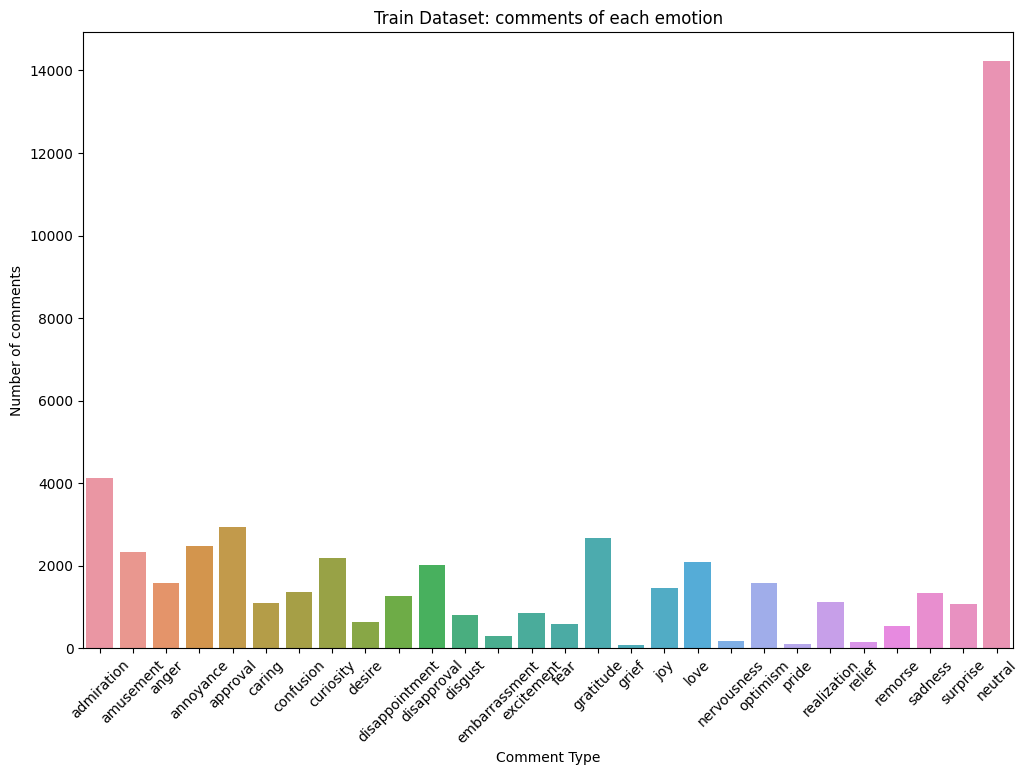

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=categories, y=y_train.sum().values)
plt.title("Train Dataset: comments of each emotion")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type')
plt.xticks(rotation=45)
plt.show()

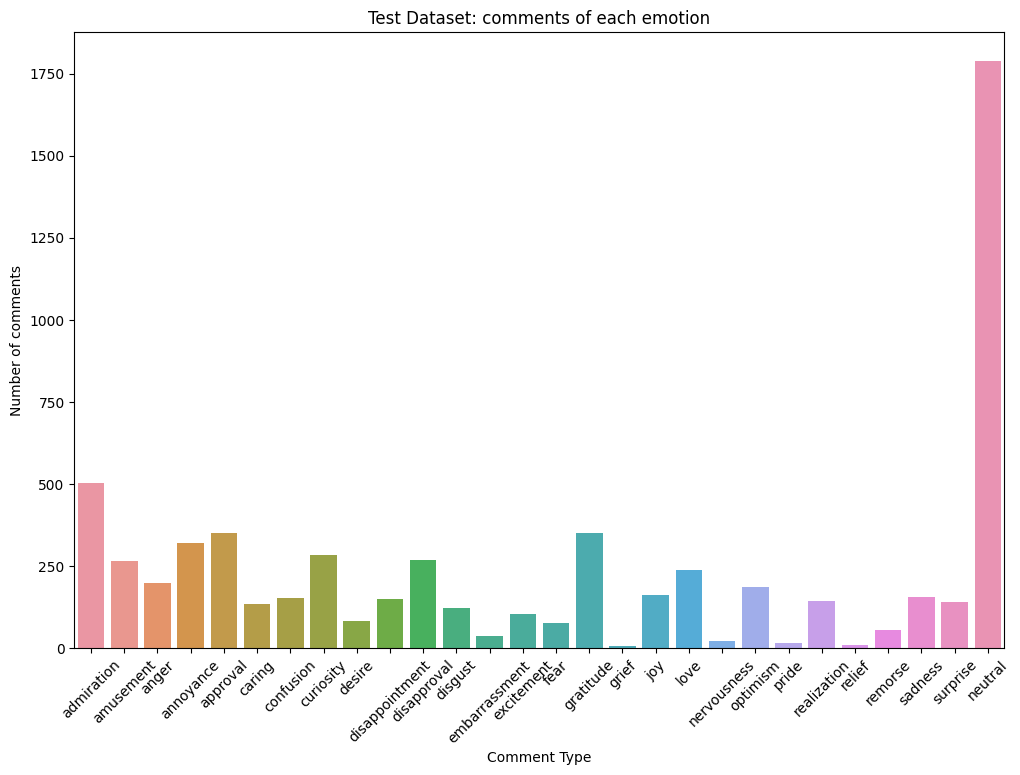

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=categories, y=y_test.sum().values)
plt.title("Test Dataset: comments of each emotion")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type')
plt.xticks(rotation=45)
plt.show()

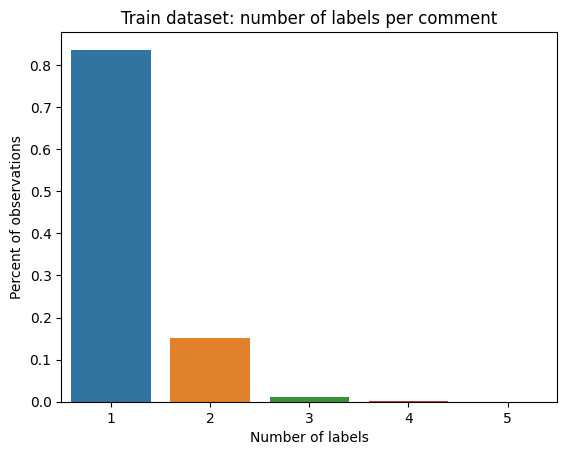

In [ ]:
rowSums = y_train.sum(axis=1)
multiLabel_counts = rowSums.value_counts()
#multiLabel_counts = multiLabel_counts.iloc[1:]
ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values/sum(multiLabel_counts))
plt.title("Train dataset: number of labels per comment")
plt.ylabel('Percent of observations')
plt.xlabel('Number of labels')
plt.show()

In [ ]:
multiLabel_counts / sum(multiLabel_counts)

1    0.836397
2    0.150680
3    0.012255
4    0.000645
5    0.000023
dtype: float64

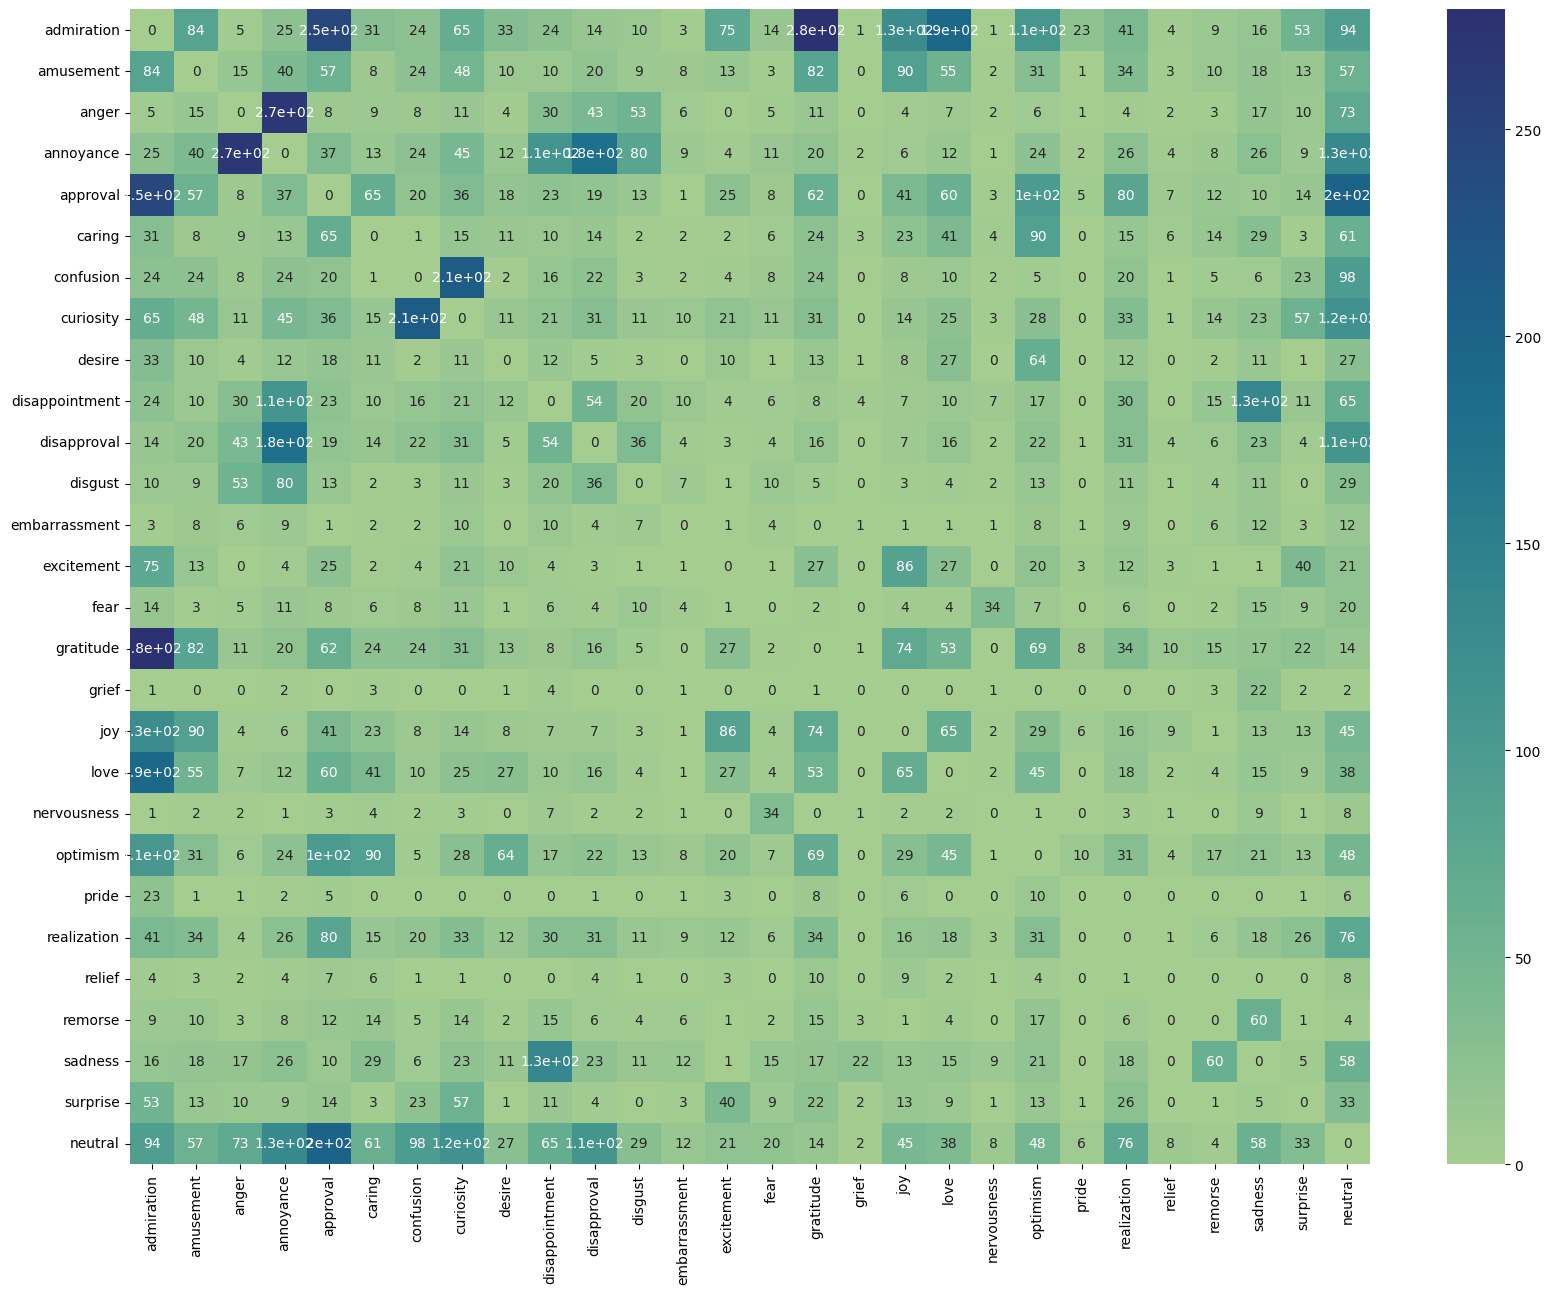

In [ ]:
coocc = y_train.T.dot(y_train)
np.fill_diagonal(coocc.values, 0)
plt.subplots(figsize=(20,15))
sns.heatmap(coocc,cmap="crest",annot=True)
plt.show()

In [ ]:
X_train_word_count = X_train.apply(lambda x: len(x.split()))
X_test_word_count = X_test.apply(lambda x: len(x.split()))

In [ ]:
X_train_word_count.describe()

count    43410.000000
mean        12.840175
std          6.701597
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: text, dtype: float64

In [ ]:
X_test_word_count.describe()

count    5427.000000
mean       12.726000
std         6.672055
min         1.000000
25%         7.000000
50%        12.000000
75%        18.000000
max        32.000000
Name: text, dtype: float64

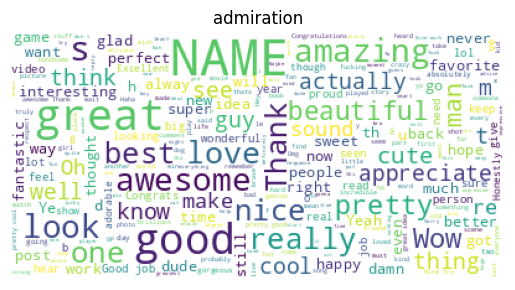

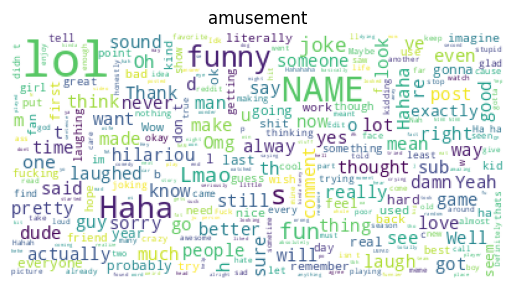

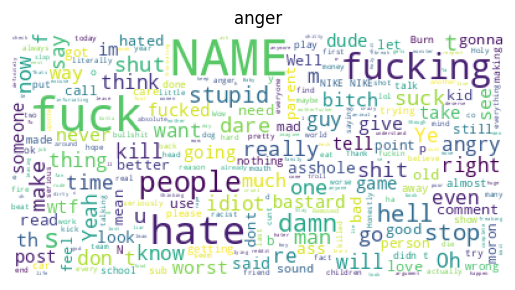

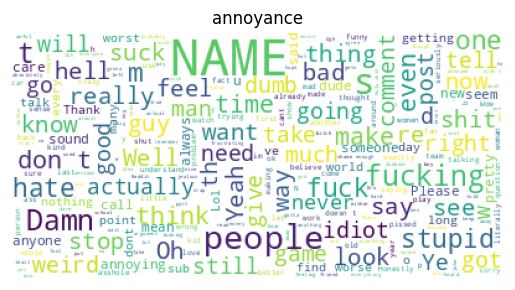

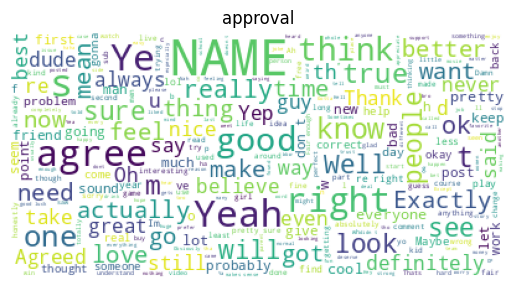

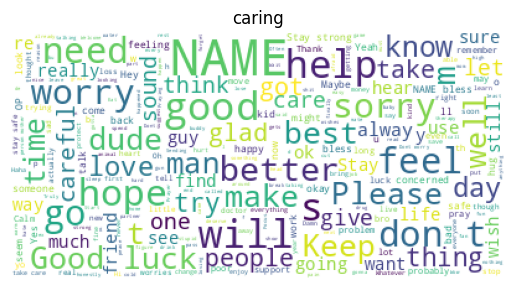

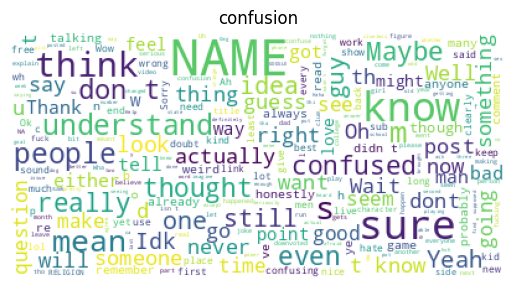

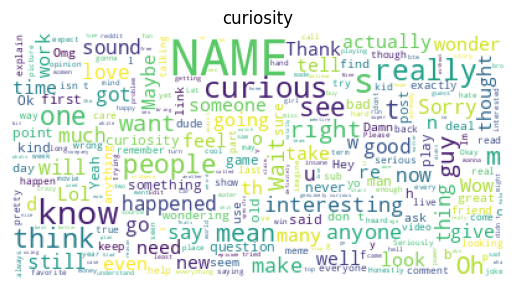

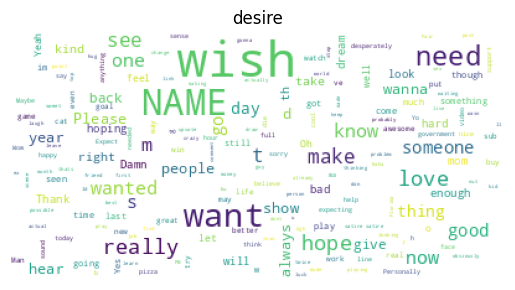

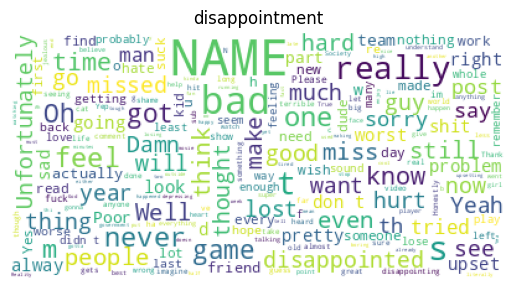

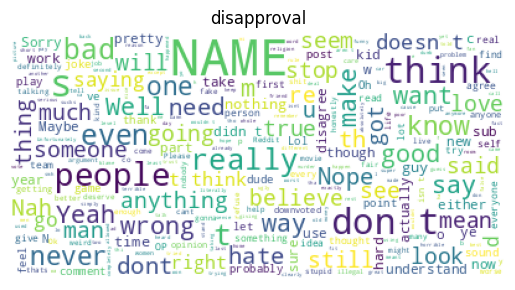

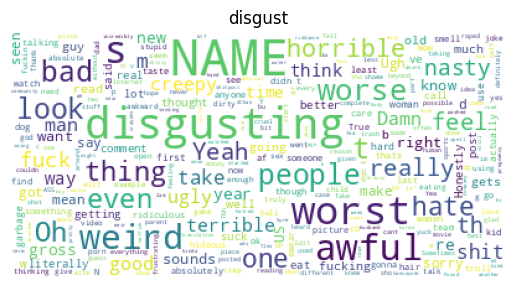

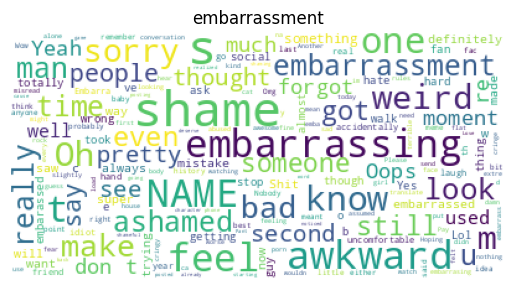

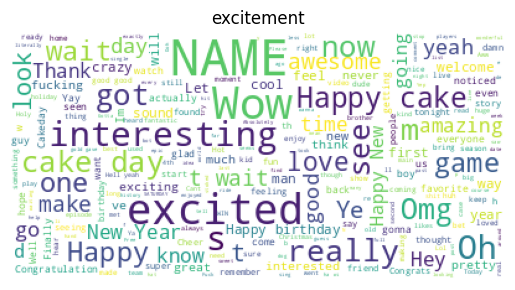

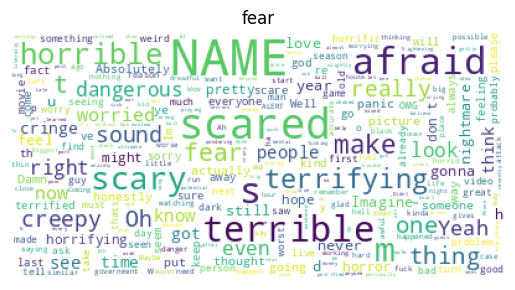

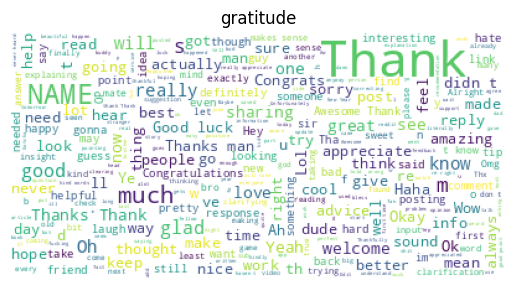

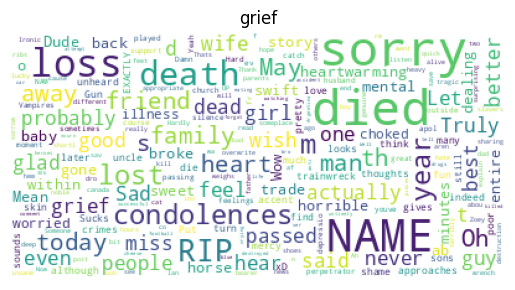

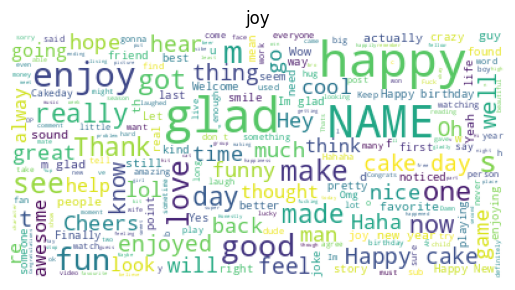

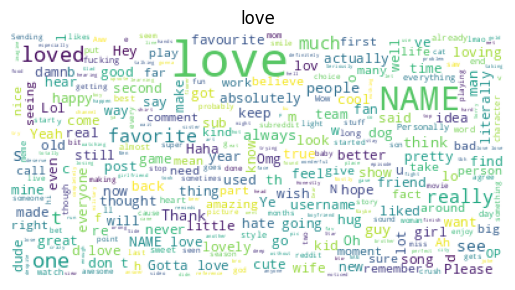

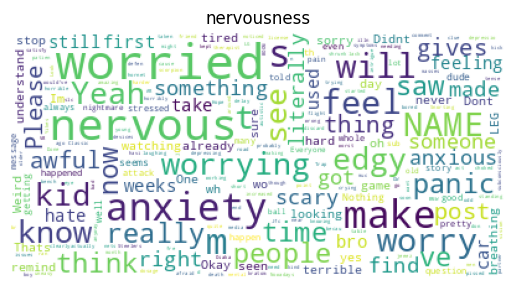

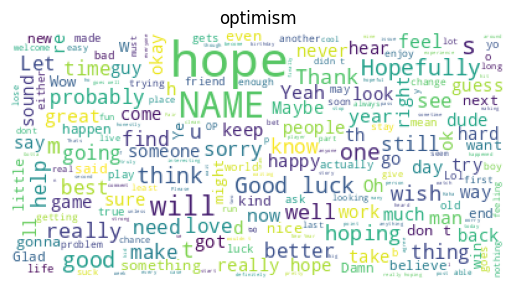

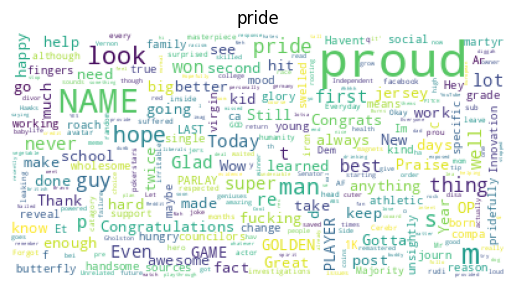

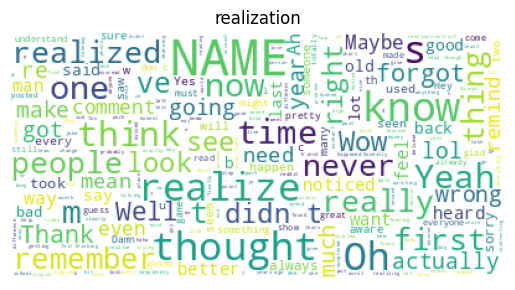

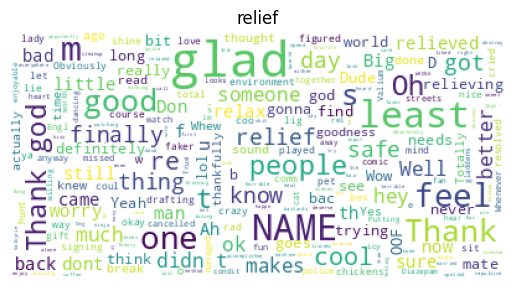

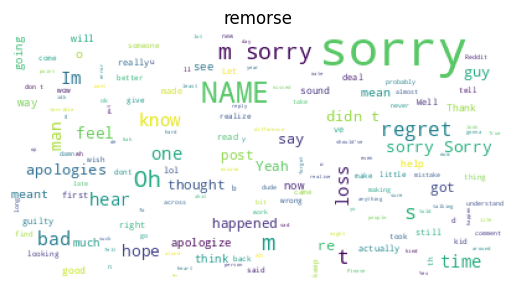

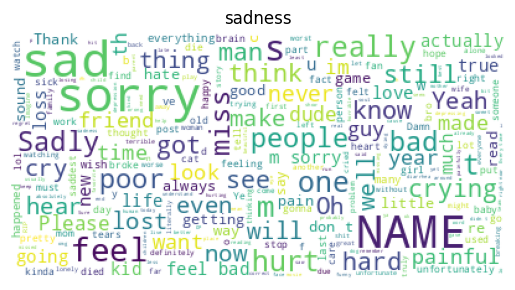

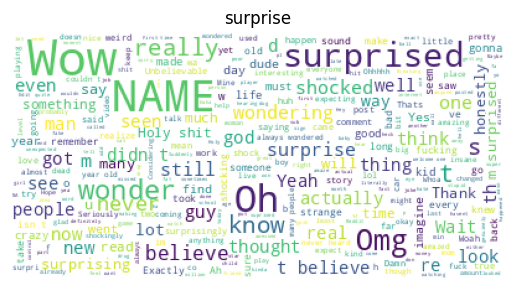

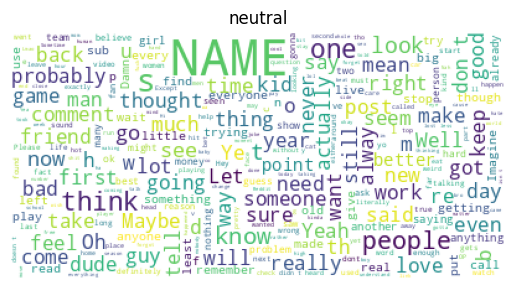

In [ ]:
sw = nltk.corpus.stopwords.words('english').extend(["[NAME]","NAME"])
for cat in y_train.columns:
	wc = WordCloud(background_color="white", max_words=2000, stopwords=sw,
                   max_font_size=40, random_state=42)
	wc.generate(X_train[y_train[cat] == 1].to_string())
	plt.imshow(wc)
	plt.title(cat)
	plt.axis("off")
	plt.show()

# Preprocessing

Here we preprocess the data for the baseline and RNN classifiers by lowercasing, removing stopwords, and stemming.

In [ ]:
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

X_train = X_train.apply(lambda x: remove_stopwords(x))
X_train = X_train.apply(lambda x:clean_text(x))
X_train = X_train.apply(stemming)

X_test = X_test.apply(lambda x: remove_stopwords(x))
X_test = X_test.apply(lambda x:clean_text(x))
X_test = X_test.apply(stemming)

In [ ]:
X_train

0        i would say horribl accid also wrong the milit...
1                                     done good luck thing
2                                                 now epic
3                                               eat better
4        so stay theft auto wait dispatch next shift ba...
                               ...                        
43405                                         what name do
43406                                        wont fuck die
43407                   rip sad famili bull ride communiti
43408                            i hot dog they delici lol
43409    i mean st coach market seem littl dri mayb bes...
Name: text, Length: 43410, dtype: object

# Rebalance classes

Rebalancing multi-label data is difficult because of the many possible label combinations. For simple testing purposes, we simply drop 80% of the neutral observations, so that there is not such a large label imbalance. During testing we discovered that rebalancing classes did not improve performance, and thus we leave this as a future task to experiment with resampling the data.

In [ ]:
def rebalance(X_train,y_train):

  X = X_train.copy()
  y = y_train.copy()
  rows = y['neutral'] == 1
  num_neutrals = sum(rows) #count neutral observations
  neutral = list(y[y['neutral'] == 1].index) #save the locations of the neutral observations
  resample = int(np.floor(0.8*sum(rows))) #calculate observations to drop
  delete = random.sample(neutral,resample)
  delete.sort(reverse=True)
  for i in delete:
    X.drop(X.index[i], inplace=True)
    y.drop(y.index[i], inplace=True)

  return X, y

In [ ]:
X_train_balanced, y_train_balanced = rebalance(X_train,y_train)
y_train_balanced.shape

(32035, 28)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, 'admiration'),
  Text(1, 0, 'amusement'),
  Text(2, 0, 'anger'),
  Text(3, 0, 'annoyance'),
  Text(4, 0, 'approval'),
  Text(5, 0, 'caring'),
  Text(6, 0, 'confusion'),
  Text(7, 0, 'curiosity'),
  Text(8, 0, 'desire'),
  Text(9, 0, 'disappointment'),
  Text(10, 0, 'disapproval'),
  Text(11, 0, 'disgust'),
  Text(12, 0, 'embarrassment'),
  Text(13, 0, 'excitement'),
  Text(14, 0, 'fear'),
  Text(15, 0, 'gratitude'),
  Text(16, 0, 'grief'),
  Text(17, 0, 'joy'),
  Text(18, 0, 'love'),
  Text(19, 0, 'nervousness'),
  Text(20, 0, 'optimism'),
  Text(21, 0, 'pride'),
  Text(22, 0, 'realization'),
  Text(23, 0, 'relief'),
  Text(24, 0, 'remorse'),
  Text(25, 0, 'sadness'),
  Text(26, 0, 'surprise'),
  Text(27, 0, 'neutral')])

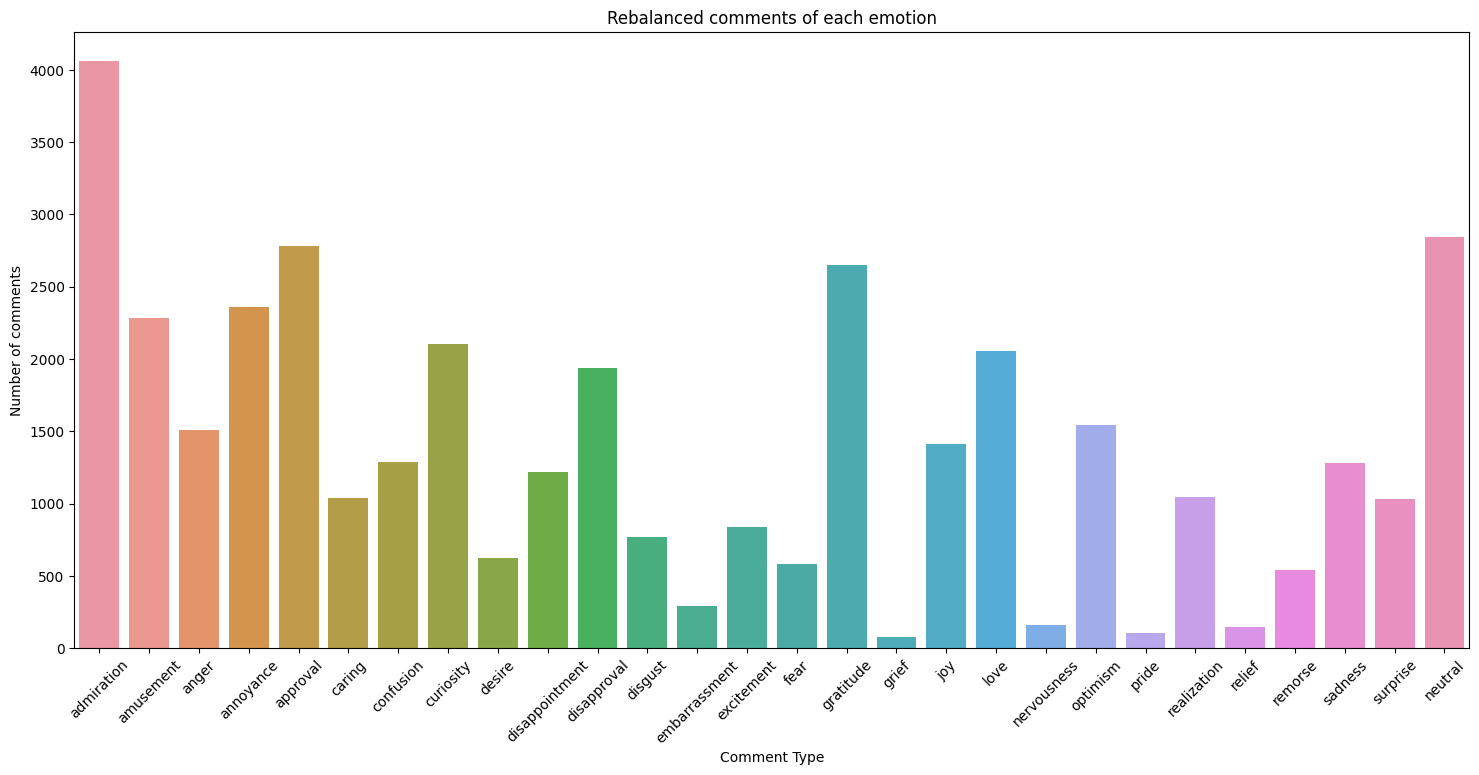

In [ ]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x=categories, y=y_train_balanced.sum().values)
plt.title("Rebalanced comments of each emotion")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type')
plt.xticks(rotation=45)

# Random classifier

Our random classifier randomly selects one of 27 emotion labels or neutral. Predictably, it performs poorly.

In [ ]:
def random_multilabel_classifier(X):
  n_categories = 28
  n_obs = X.shape[0]
  pred_matrix = np.zeros((n_obs,n_categories))
  predictions = random.choices(range(n_categories),k=n_obs)
  for i in range(n_obs):
    choice = predictions[i]
    pred_matrix[i,choice] = 1

  return pred_matrix

In [ ]:
y_pred = random_multilabel_classifier(X_test)

In [ ]:
print('Precision = ', precision_score(np.asarray(y_test),y_pred,average='macro'))
print('Recall = ', recall_score(np.asarray(y_test),y_pred,average='macro'))
print('F1 score is ',f1_score(np.asarray(y_test), y_pred,average="macro"))

Precision =  0.04240788324435575
Recall =  0.03877448526392025
F1 score is  0.030912363114234793


In [ ]:
print(classification_report(y_test, y_pred,target_names=LABELS))

                precision    recall  f1-score   support

    admiration       0.09      0.03      0.05       504
     amusement       0.06      0.04      0.05       264
         anger       0.04      0.05      0.04       198
     annoyance       0.05      0.03      0.04       320
      approval       0.04      0.02      0.03       351
        caring       0.03      0.04      0.04       135
     confusion       0.03      0.04      0.03       153
     curiosity       0.06      0.04      0.05       284
        desire       0.01      0.02      0.01        83
disappointment       0.04      0.05      0.04       151
   disapproval       0.05      0.03      0.04       267
       disgust       0.03      0.05      0.04       123
 embarrassment       0.01      0.03      0.01        37
    excitement       0.03      0.06      0.04       103
          fear       0.00      0.00      0.00        78
     gratitude       0.06      0.03      0.04       352
         grief       0.01      0.17      0.01  

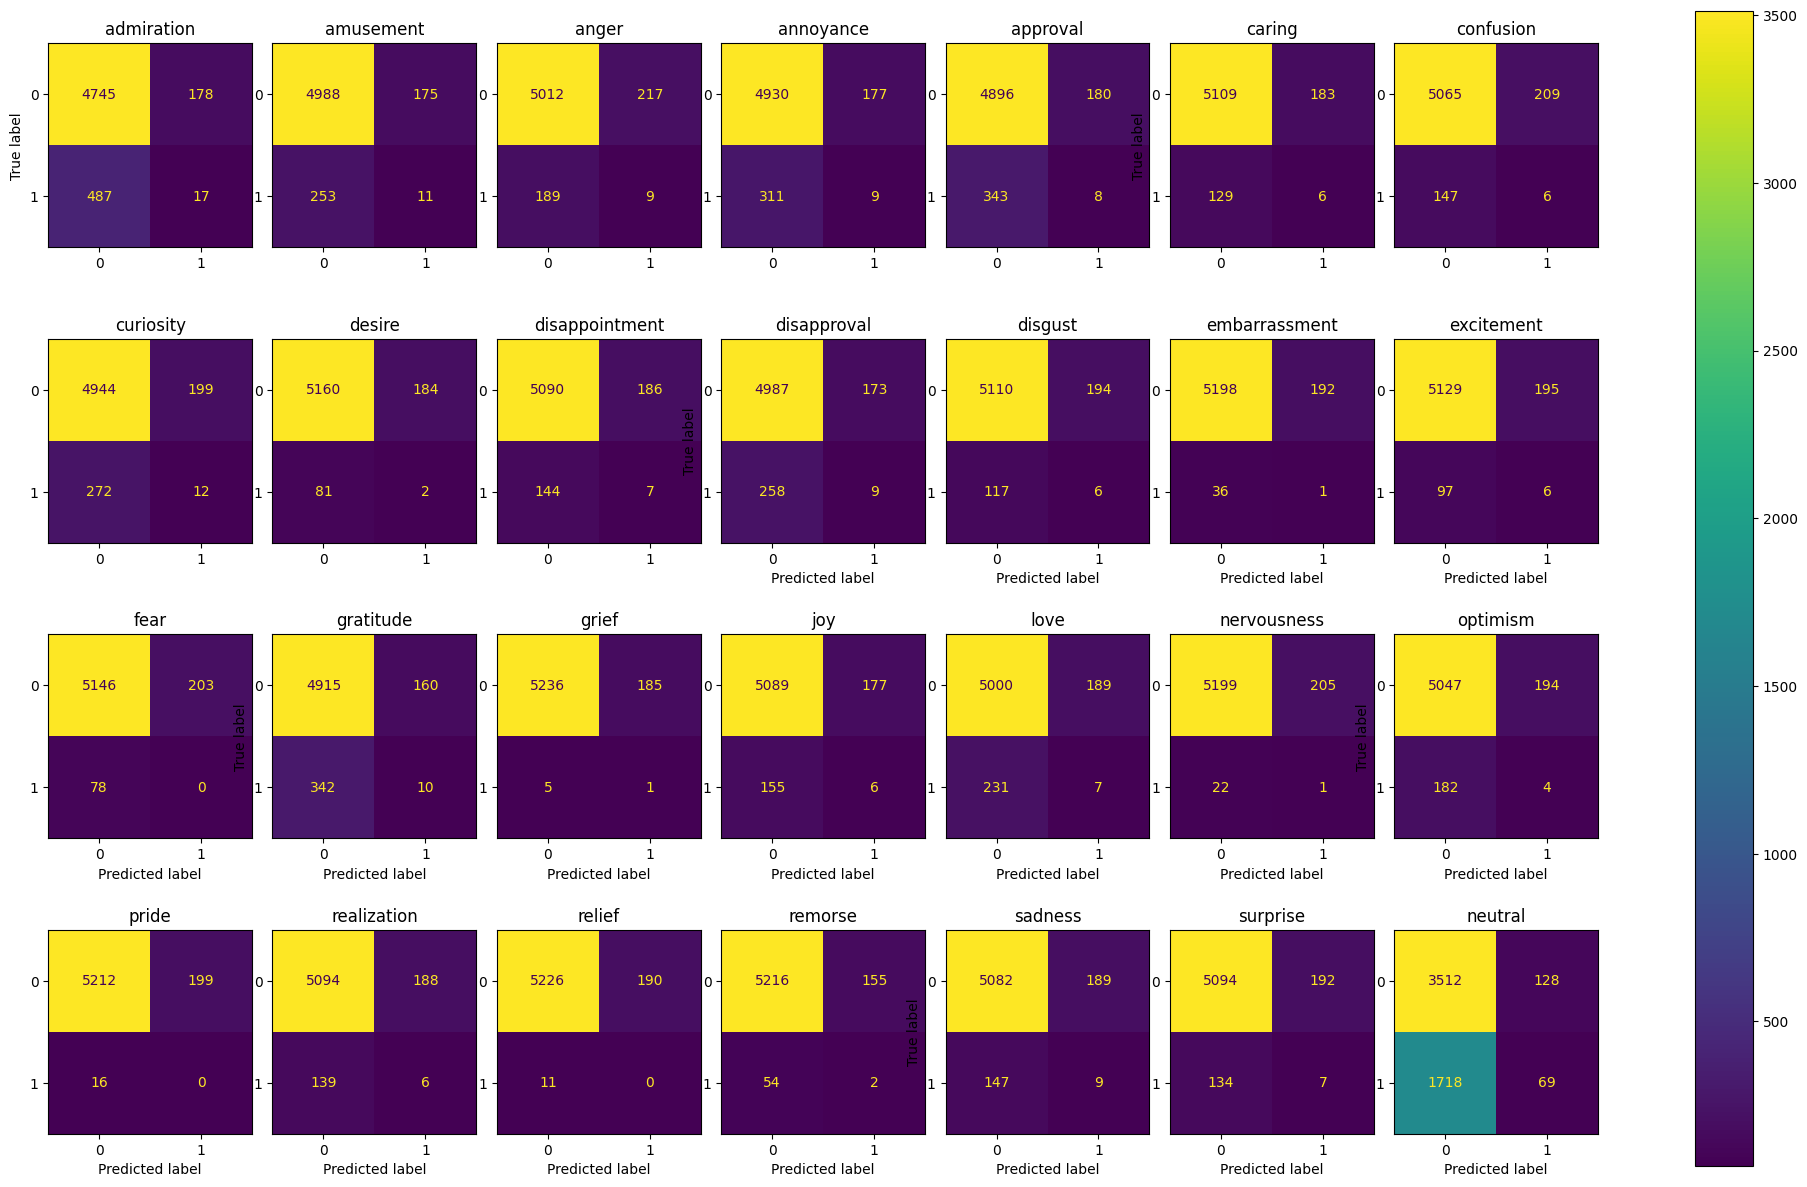

In [ ]:
cm = multilabel_confusion_matrix(np.asarray(y_test),y_pred)
f, axes = plt.subplots(4, 7, figsize=(25, 15))
axes = axes.ravel()
for i in range(y_pred.shape[1]):
    disp = ConfusionMatrixDisplay(cm[i],
                                  display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(LABELS[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# Baseline classifier

Our baseline classifier vectorizes the samples into a TF-IDF matrix based on the vocabulary in the training set. It ignores words that appear in over 10% of the corpus, with only the top 3,000 words considered to reduce dimensionality.  

We then use a One vs. Rest logistic regression classifier and grid search over the regularization parameter $C$.

The model does perform decently compared to the SoA BERT model, despite the crudeness of the method.

In [ ]:
tfidfvectorizer = TfidfVectorizer(analyzer='word' , stop_words='english',max_df=0.1,max_features=3000)
tfidfvectorizer.fit(X_train)
tfidf_train = tfidfvectorizer.transform(X_train)
tfidf_test = tfidfvectorizer.transform(X_test)

In [ ]:
# Grid search for best C value
C_range = [0.0001,0.001,0.01,0.1]
for i in C_range:
  clf = OneVsRestClassifier(LogisticRegression(class_weight='balanced',C = i, solver =  'sag'), n_jobs=-1)
  clf.fit(tfidf_train, np.asarray(y_train))
  y_pred = clf.predict(tfidf_test)
  f1_score_cv = f1_score(np.asarray(y_test), y_pred,average="macro")
  print("C:", i, "F1-Score:",f1_score_cv)


C: 0.0001 F1-Score: 0.3855167603822355
C: 0.001 F1-Score: 0.3865103729304938
C: 0.01 F1-Score: 0.3707414575576878
C: 0.1 F1-Score: 0.33410778249569384


In [ ]:
classifier = OneVsRestClassifier(LogisticRegression(class_weight='balanced',solver='sag',C=0.001), n_jobs=-1)
classifier.fit(tfidf_train, np.asarray(y_train))
y_pred = classifier.predict(tfidf_test)
y_probs = classifier.predict_proba(tfidf_test)

In [ ]:
#returns the labels corresponding to binary predictions
def get_labels(x):
  lbls = [LABELS[i] for i in range(len(x)) if x[i] == 1]
  return lbls

See below an example of predicted output.

In [ ]:
baseline_results = pd.DataFrame(X_test_raw)
y_pred_labels = []
y_true_labels = []
for i in range(len(y_pred)):
  y_pred_labels.append(get_labels(y_pred[i]))
  y_true_labels.append(get_labels(np.asarray(y_test)[i]))
baseline_results["predicted_label"] = y_pred_labels
baseline_results["true_label"] = y_true_labels
baseline_results.head(10)

text  \
0  I must've missed them. Looking again but if yo...   
1  It hasn’t happened yet. Just talk to the super...   
2          Break ups are hard. Hope you feel better.   
3                        Thank you and your upvoters   
4  Because they are triggered. I’m just stating m...   
5  It would be a little less irritating if the 10...   
6  Not at all. It's great of course for financial...   
7                     Saving this. Happy 2019 to ya!   
8  It's honestly the best news I've heard all sea...   
9  Help me [NAME] I'm bully in high school for no...   

                                     predicted_label              true_label  
0  [curiosity, disappointment, realization, sadne...  [confusion, curiosity]  
1  [annoyance, caring, confusion, curiosity, disa...                [caring]  
2  [caring, disappointment, optimism, relief, sad...                [caring]  
3                                        [gratitude]             [gratitude]  
4                  [curiosity, disapproval, neutral]             [amusement]  
5                       [annoyance, desire, neutral]    [annoyance, neutral]  
6        [admiration, approval, caring, nervousness]               [sadness]  
7                          [caring, excitement, joy]       [excitement, joy]  
8                          [admiration, realization]                   [joy]  
9                                  [caring, neutral]                  [fear]

In [ ]:
print('Precision = ', precision_score(np.asarray(y_test),y_pred,average='macro'))
print('Recall = ', recall_score(np.asarray(y_test),y_pred,average='macro'))
print('F1 score is ',f1_score(np.asarray(y_test), y_pred,average="macro"))

Precision =  0.3372145246733111
Recall =  0.5925932008467634
F1 score is  0.38752996482713503


In [ ]:
print(classification_report(y_test, y_pred,target_names=LABELS))

                precision    recall  f1-score   support

    admiration       0.48      0.61      0.54       504
     amusement       0.77      0.70      0.73       264
         anger       0.35      0.42      0.38       198
     annoyance       0.18      0.56      0.27       320
      approval       0.18      0.52      0.27       351
        caring       0.10      0.53      0.16       135
     confusion       0.12      0.56      0.19       153
     curiosity       0.12      0.51      0.20       284
        desire       0.21      0.51      0.30        83
disappointment       0.09      0.41      0.15       151
   disapproval       0.11      0.56      0.18       267
       disgust       0.37      0.63      0.47       123
 embarrassment       0.27      0.41      0.33        37
    excitement       0.12      0.49      0.20       103
          fear       0.52      0.76      0.61        78
     gratitude       0.96      0.86      0.91       352
         grief       0.06      1.00      0.11  

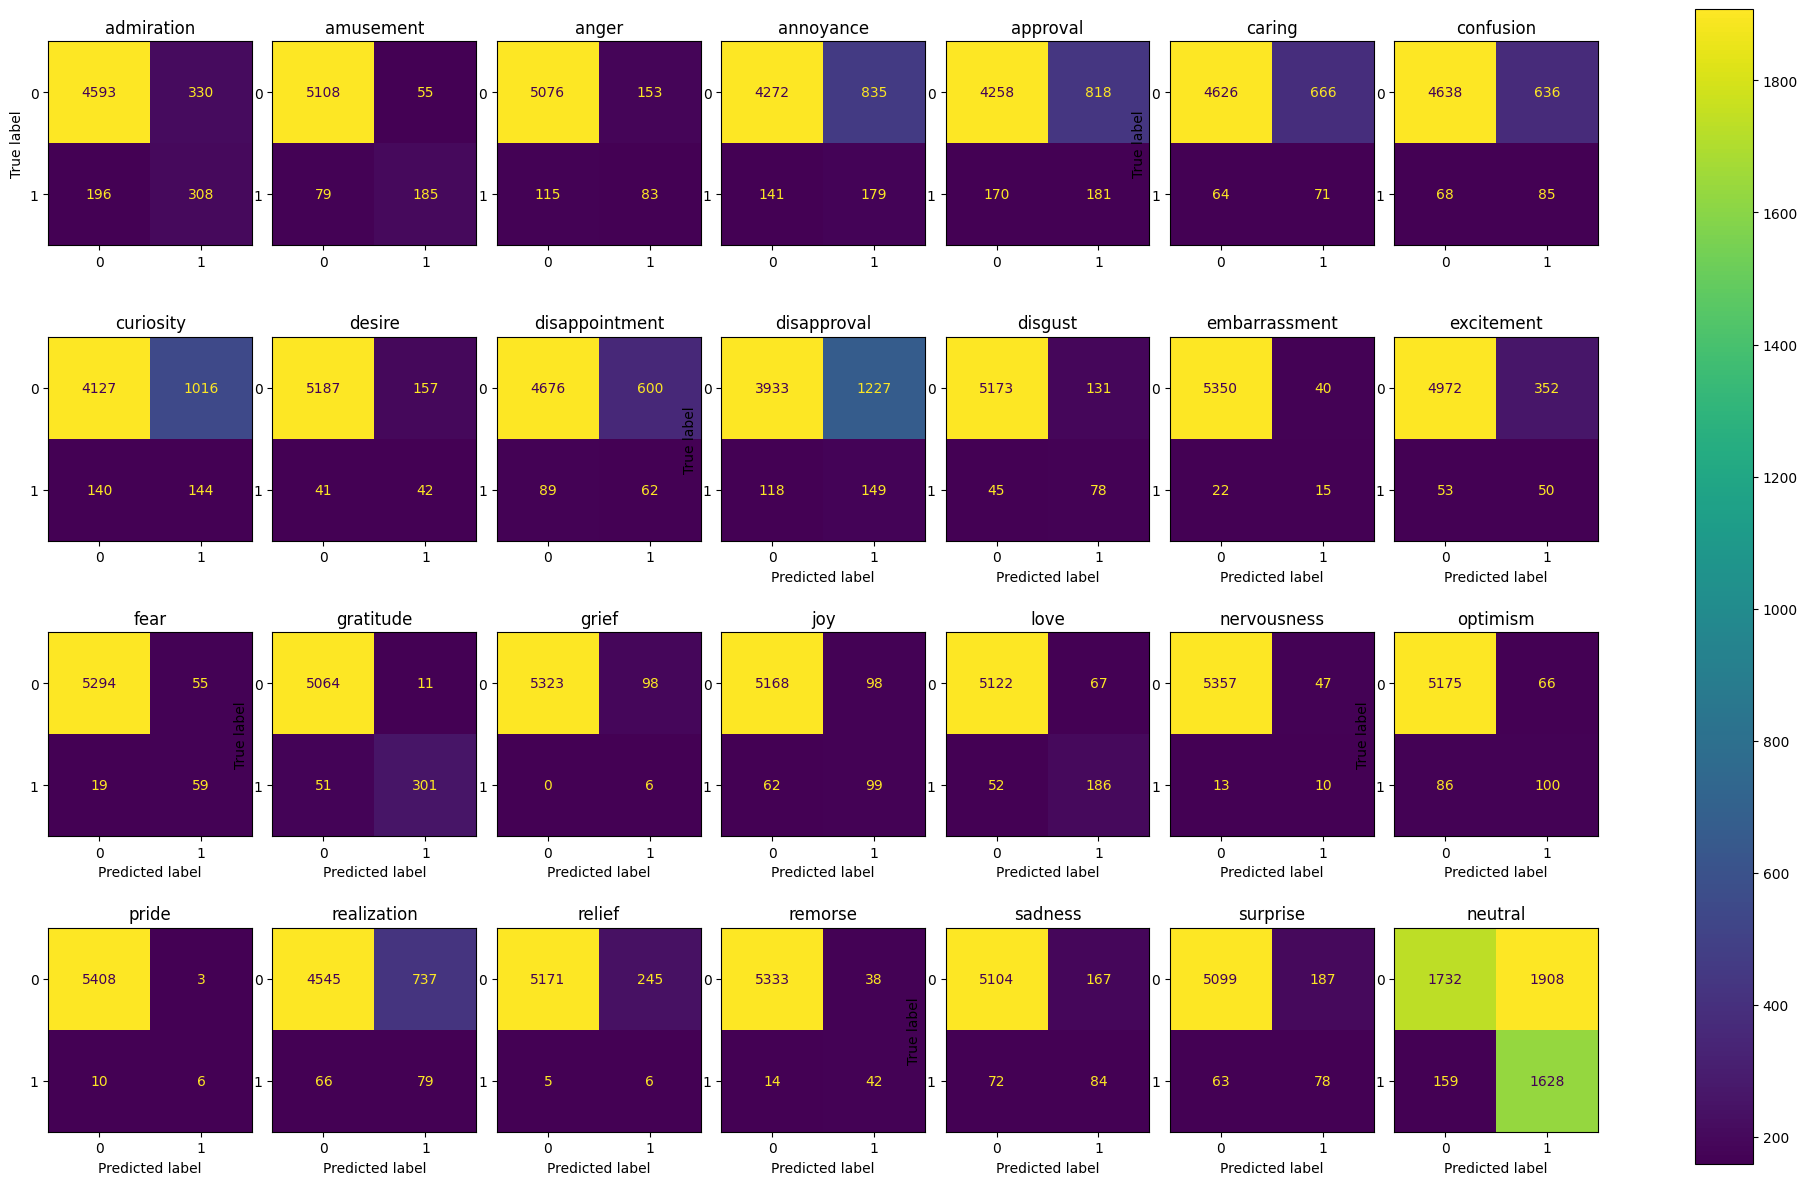

In [ ]:
cm = multilabel_confusion_matrix(np.asarray(y_test),y_pred)
f, axes = plt.subplots(4, 7, figsize=(25, 15))
axes = axes.ravel()
for i in range(y_pred.shape[1]):
    disp = ConfusionMatrixDisplay(cm[i],
                                  display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(LABELS[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

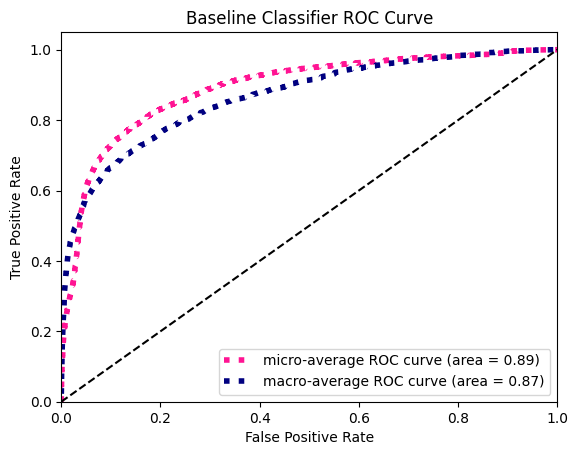

In [ ]:
plot_roc_auc(y_probs,y_test, title = 'Baseline Classifier ROC Curve')

# RNN classifier

For our RNN classifier, we build a model with an embedding layer, one LSTM layer, and one dense layer with a sigmoid softmax activation function. We tokenize and pad the text inputs and train for 30 epochs with a batch size of 16. It is much more precise than the baseline classifier, but with a lower recall.

**Training the model**

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.optimizers import RMSprop, Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import AUC
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score

# Define the number of classes
num_classes = 28

# Define the maximum length of input sequence
max_seq_length = max(max(len(sentence.split()) for sentence in X_train), max(len(sentence.split()) for sentence in X_test))

# Define the number of unique words in the vocabulary
#word_set = set()
#for sentence in X_train:
#    for word in sentence.split():
#        word_set.add(word)
#vocab_size = len(word_set)

# Accuracy
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

# Metrics
metrics = [
    multi_label_accuracy,
    "binary_accuracy",
    AUC(name="average_precision", curve="PR", multi_label=True)
]

# Loss function
loss = BinaryCrossentropy(from_logits = True)

## MODEL ##

# Initialize a Sequential model
#model = Sequential()

# Add an Embedding layer to convert the input text to dense vectors
# Note... From documentation: output_dim: Integer. Dimension of the dense embedding.
#model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_seq_length))

# Add an LSTM layer to capture the context in the input sequence
#model.add(LSTM(units=32))

# Add a Dense layer with softmax activation to output probabilities for each class
#model.add(Dense(units=num_classes, activation='sigmoid'))

#Define the algorithm for gradient descent
#optimizer = RMSprop(learning_rate=0.001)

# Compile the model with categorical cross-entropy loss and Adam optimizer
#model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Train the model with the given training data
#model.fit(x_train_padded, y_train_np, validation_data=(x_test_padded, y_test_np), epochs=20, batch_size=16)

**Loading the model**

In [ ]:
## Reload the necessary custom accuracy/metrics functions

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.optimizers import RMSprop, Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import AUC
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score

# Accuracy
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [ ]:
## Load the model ##

from keras.models import load_model
rnn_model = load_model('/content/gdrive/MyDrive/go_emotions/rnn_model.h5', custom_objects={'multi_label_accuracy': multi_label_accuracy})

**Get predictions on test set**

In [ ]:
import numpy as np
np.random.seed(123)

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
x_train_seq = tokenizer.texts_to_sequences(X_train)
x_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to a fixed length
max_seq_length = max(max(len(sentence.split()) for sentence in X_train), max(len(sentence.split()) for sentence in X_test))
x_train_padded = pad_sequences(x_train_seq, maxlen=max_seq_length)
x_test_padded = pad_sequences(x_test_seq, maxlen=max_seq_length)

# Convert to numpy arrays
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Print shapes to ensure they are correct sizes
print(x_train_padded.shape)
print(y_train_np.shape)
print(x_test_padded.shape)
print(y_test_np.shape)

(43410, 33)
(43410, 28)
(5427, 33)
(5427, 28)


In [ ]:
# Evaluate the model on the test data
y_pred = rnn_model.predict(x_test_padded)
y_probs = y_pred.copy()
y_pred = (y_pred > 0.5).astype(int) # convert probabilities to binary predictions
y_test_np = y_test_np.astype(int) # ensure that y_test is of integer type

# Print classification report
print(classification_report(y_test_np, y_pred))

170/170 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.65      0.55      0.59       504
           1       0.77      0.74      0.76       264
           2       0.43      0.23      0.30       198
           3       0.37      0.21      0.27       320
           4       0.33      0.19      0.24       351
           5       0.30      0.16      0.20       135
           6       0.38      0.19      0.25       153
           7       0.39      0.19      0.26       284
           8       0.53      0.19      0.28        83
           9       0.32      0.07      0.12       151
          10       0.23      0.12      0.15       267
          11       0.55      0.28      0.37       123
          12       0.50      0.24      0.33        37
          13       0.52      0.22      0.31       103
          14       0.82      0.47      0.60        78
          15       0.92      0.86      0.89       352
          16       0.00   

**ROC/AUC plot and sample output**

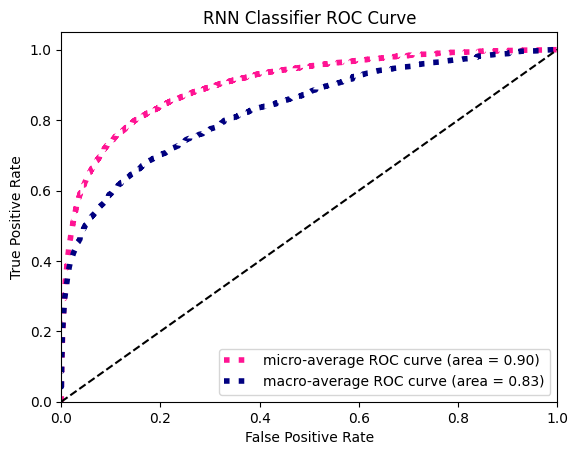

In [ ]:
plot_roc_auc(y_probs,y_test,"RNN Classifier ROC Curve")

In [ ]:
rnn_results = pd.DataFrame(X_test_raw)
y_pred_labels = []
y_true_labels = []
for i in range(len(y_pred)):
  y_pred_labels.append(get_labels(y_pred[i]))
  y_true_labels.append(get_labels(np.asarray(y_test)[i]))
rnn_results["predicted_label"] = y_pred_labels
rnn_results["true_label"] = y_true_labels
rnn_results.head(10)

text   predicted_label  \
0  I must've missed them. Looking again but if yo...  [disappointment]   
1  It hasn’t happened yet. Just talk to the super...                []   
2          Break ups are hard. Hope you feel better.        [optimism]   
3                        Thank you and your upvoters       [gratitude]   
4  Because they are triggered. I’m just stating m...       [amusement]   
5  It would be a little less irritating if the 10...       [annoyance]   
6  Not at all. It's great of course for financial...             [joy]   
7                     Saving this. Happy 2019 to ya!    [joy, neutral]   
8  It's honestly the best news I've heard all sea...      [admiration]   
9  Help me [NAME] I'm bully in high school for no...                []   

               true_label  
0  [confusion, curiosity]  
1                [caring]  
2                [caring]  
3             [gratitude]  
4             [amusement]  
5    [annoyance, neutral]  
6               [sadness]  
7       [excitement, joy]  
8                   [joy]  
9                  [fear]

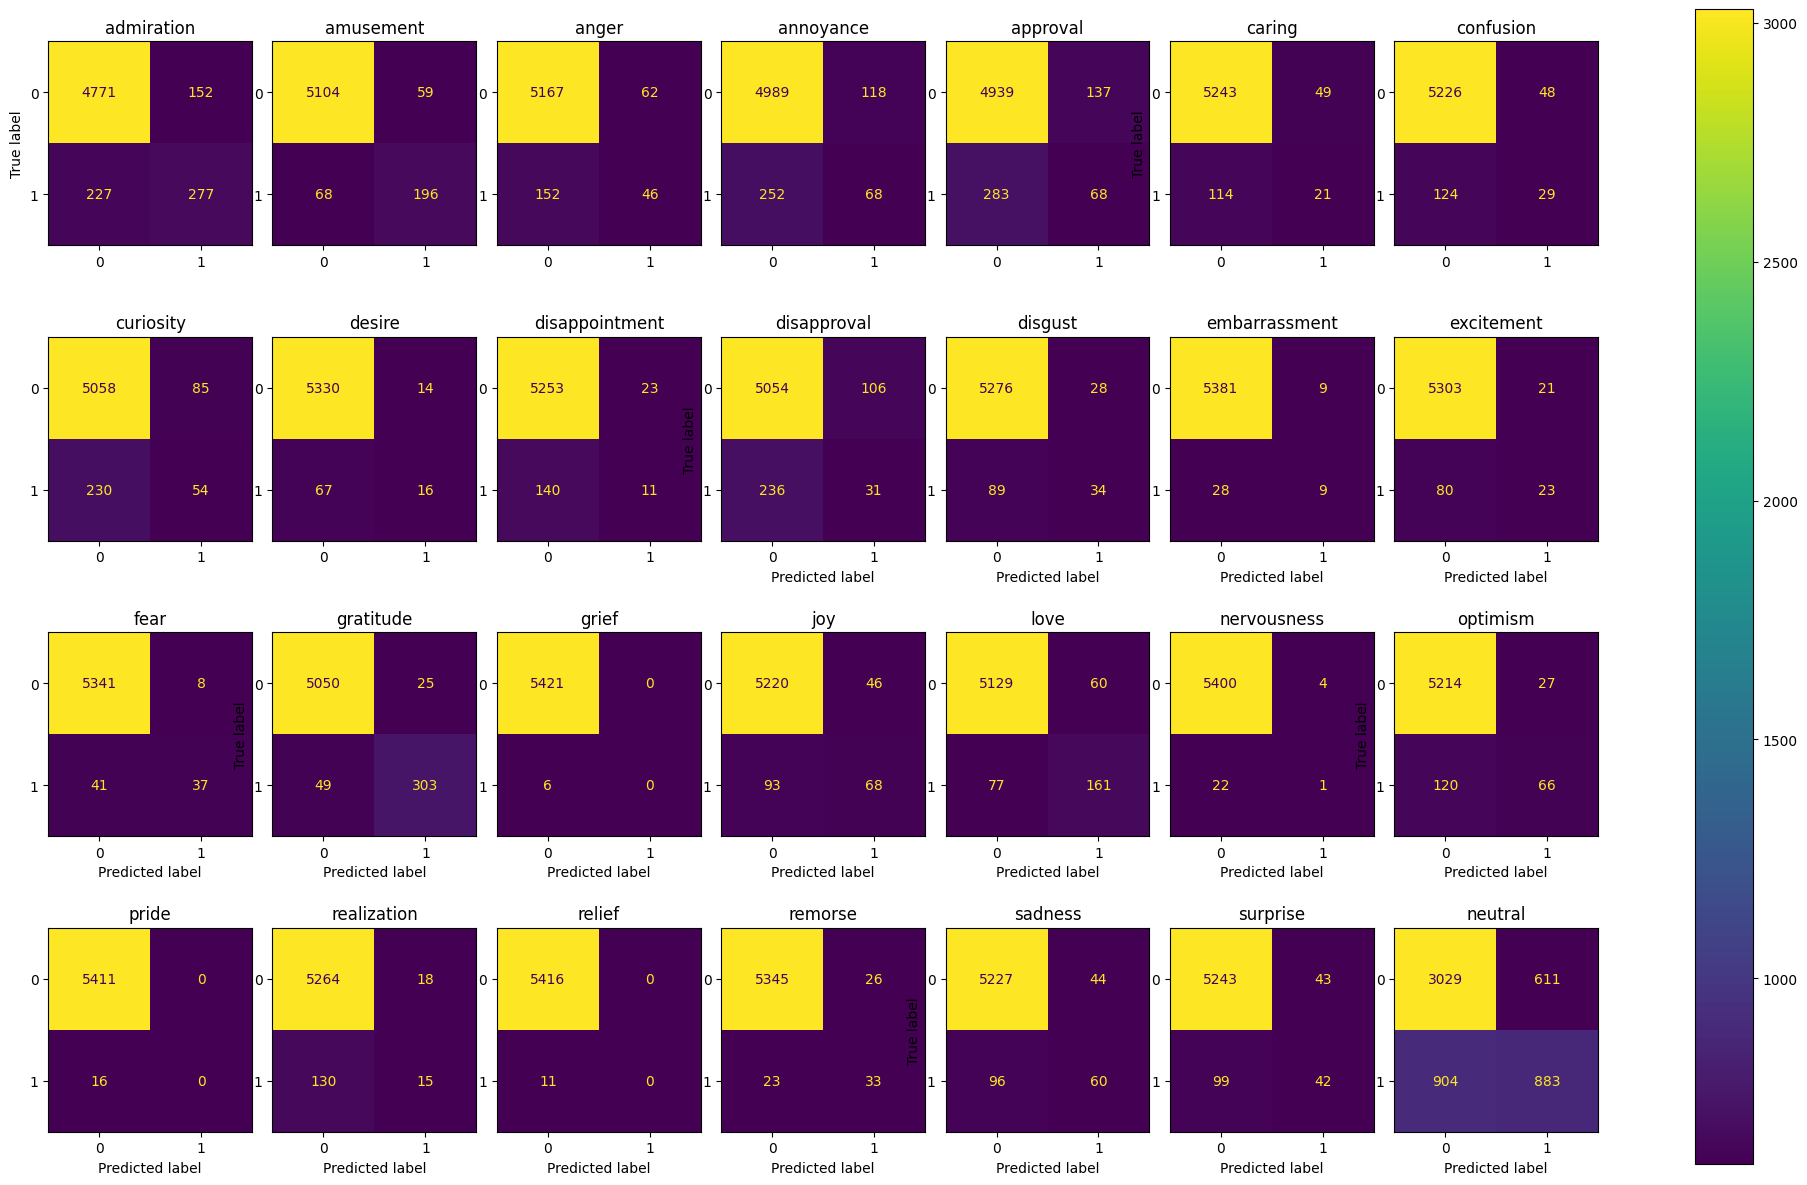

In [ ]:
cm = multilabel_confusion_matrix(np.asarray(y_test),y_pred)
f, axes = plt.subplots(4, 7, figsize=(25, 15))
axes = axes.ravel()
for i in range(y_pred.shape[1]):
    disp = ConfusionMatrixDisplay(cm[i],
                                  display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(LABELS[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# EmoDistillBERT

As the last step we choose to fit a pretrained large language BERT-like model, more specifically DistilBERT. The training of this model can be found in `EmoBertTraining.ipynb`.

We have started with adding a dense fully-connected layer onto the BERT embedding unit. The dense layer is comprised of the sigmoid activation function which is crucial fo the multi-label nature of our dataset. Specifically, it allows us to model the probability distributions with dependencies and not as independent quantities (like the softmax function would, by forcing the predicted probabilities sum up to 1). With this, we do not have normalized distributions and observations are allowed to belong in multiple categories at once. We also add a dropout layer with value 0.7 to increase robustness of the model, as lower dropout resulted in overfitting.

As for loss function, we have chosen Binary Cross Entopy with logits, as this will treat the observations as distance from true value (0 or 1).

We have then optimized using Adam optimizer with step size  $10^{-5}$.

During training we have tried to only train the added dense layer. This approach was not able to capture dependencies and correctly categorize the data. We have then trained the full model with all $\approx 66$ mil. weights for 10 epochs, considering the validation loss as a possible means to stop the training sooner (this has not happened as the loss kept decreasing). Given the large amounts of data at hand and only slight improvements in perfomance, we chose to stop after.

Smaller batch size proved to be a better choice (which is probably caused by small sample sizes of sub labels (i.e. grief) which would be polluted and lost in a bigger size, the best model we chose, which is very close to SOA, has batch size 32 during training.

Note that the model outputs a sample from fitted probability distribution of a label being associated with an obsevation, to turn this into a classification task we choose a theshold value based on ROC curve plotted below as a tadeoff between the average recall and precision of the model. We choose threshold of 0.14 to show our classifier is equal to the SOA in these metrics.

In [ ]:
from bertie import * #import helper functions for bert models

## Frozen BERT

To illustrate the bad performance of model with only finetuned final dense layer we load and present the model below.

In [ ]:
bert_model = make_bert(33)
# load weights into new model
bert_model.load_weights("/content/gdrive/MyDrive/go_emotions/bert_model_frozen.h5")
print("Loaded model from disk")

loss = BinaryCrossentropy(from_logits = False)
optimizer = Adam(5e-5)
metrics = [
    multi_label_accuracy,
    "binary_accuracy",
    AUC(name="average_precision", curve="PR", multi_label=True)
]

bert_model.compile(optimizer=optimizer,
                   metrics = metrics,
                   loss = loss)
print("Compiled model")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Instructions for updating:
Lambda fuctions will be no more assumed to be

Loaded model from disk
Compiled model


In [ ]:
input_test = input_test_encode(X_test_raw,max_length = 33)
y_pred = bert_model.predict(input_test)

170/170 [==============================] - 10s 47ms/step


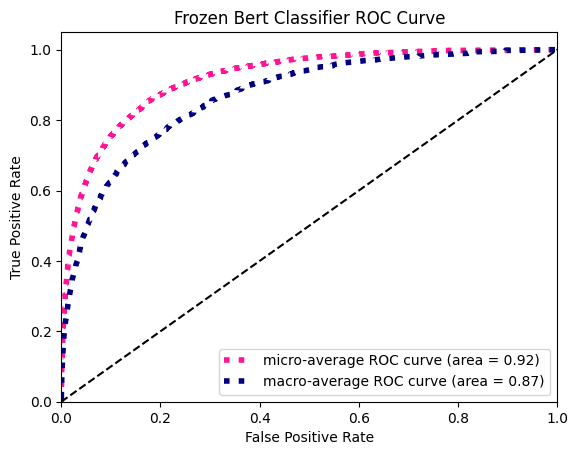

In [ ]:
plot_roc_auc(y_pred,y_test, title = 'Frozen Bert Classifier ROC Curve')

In [ ]:
y_preds = np.where(y_pred >0.14,1,0)
r_bert, p_bert = get_metrics(y_test, y_preds, verbose=True)

Precision: 28.22
Recall: 33.32


In [ ]:

print(classification_report(y_test, y_preds,target_names=LABELS))

                precision    recall  f1-score   support

    admiration       0.39      0.70      0.50       504
     amusement       0.50      0.61      0.55       264
         anger       0.32      0.43      0.37       198
     annoyance       0.22      0.27      0.25       320
      approval       0.23      0.41      0.29       351
        caring       0.33      0.30      0.31       135
     confusion       0.22      0.32      0.26       153
     curiosity       0.46      0.67      0.54       284
        desire       0.28      0.08      0.13        83
disappointment       0.23      0.10      0.14       151
   disapproval       0.28      0.27      0.27       267
       disgust       0.48      0.26      0.34       123
 embarrassment       0.00      0.00      0.00        37
    excitement       0.22      0.17      0.19       103
          fear       0.45      0.26      0.33        78
     gratitude       0.56      0.90      0.69       352
         grief       0.00      0.00      0.00  

## Fully tuned DistillBERT

We now load the pretrained model from stored weights in our folder after specifiyng the architecture below.

In [ ]:
bert_model = make_bert(33)
bert_model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 33)]         0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 33)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 33, 768),                                                    
                                 hidden_states=None                                         

In [ ]:
# load weights into new model
bert_model.load_weights("/content/gdrive/MyDrive/go_emotions/bert_model_all_SOA.h5")
print("Loaded model from disk")

loss = BinaryCrossentropy(from_logits = False)
optimizer = Adam(5e-5)
metrics = [
    multi_label_accuracy,
    "binary_accuracy",
    AUC(name="average_precision", curve="PR", multi_label=True)
]

bert_model.compile(optimizer=optimizer,
                   metrics = metrics,
                   loss = loss)
print("Compiled model")

Loaded model from disk
Compiled model


In [ ]:
input_test = input_test_encode(X_test_raw,max_length = 33)
y_pred = bert_model.predict(input_test)

170/170 [==============================] - 9s 44ms/step


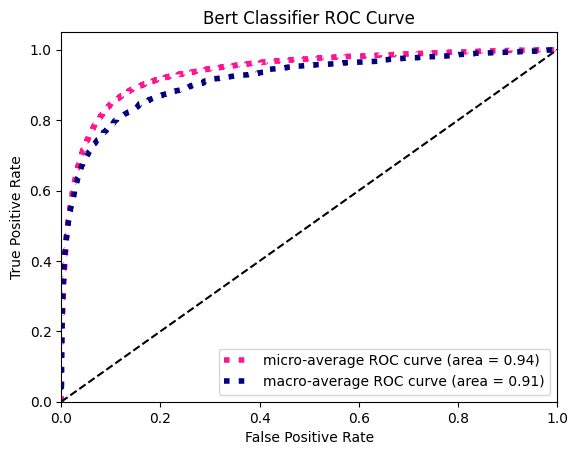

In [ ]:
plot_roc_auc(y_pred,y_test)

In [ ]:
for i in [i *0.01 for i in range(2,8)]:
  print(f'For threshold {i} the metrics are:')
  y_preds = np.where(y_pred >i,1,0)
  r_bert, p_bert = get_metrics(y_test, y_preds, verbose=True)

For threshold 0.02 the metrics are:
Precision: 24.16
Recall: 78.20
For threshold 0.03 the metrics are:
Precision: 27.26
Recall: 74.64
For threshold 0.04 the metrics are:
Precision: 29.83
Recall: 72.66
For threshold 0.05 the metrics are:
Precision: 31.60
Recall: 70.80
For threshold 0.06 the metrics are:
Precision: 33.43
Recall: 69.55
For threshold 0.07 the metrics are:
Precision: 34.77
Recall: 68.53


In [ ]:
y_preds = np.where(y_pred >0.12,1,0)
r_bert, p_bert = get_metrics(y_test, y_preds, verbose=True)

Precision: 39.89
Recall: 63.02


In [ ]:
print(classification_report(y_test, y_preds,target_names=LABELS))

                precision    recall  f1-score   support

    admiration       0.57      0.78      0.66       504
     amusement       0.73      0.89      0.80       264
         anger       0.42      0.63      0.51       198
     annoyance       0.30      0.47      0.36       320
      approval       0.22      0.59      0.32       351
        caring       0.28      0.56      0.37       135
     confusion       0.26      0.74      0.39       153
     curiosity       0.41      0.77      0.54       284
        desire       0.40      0.59      0.48        83
disappointment       0.22      0.37      0.28       151
   disapproval       0.30      0.55      0.39       267
       disgust       0.41      0.65      0.50       123
 embarrassment       0.38      0.41      0.39        37
    excitement       0.28      0.51      0.37       103
          fear       0.44      0.77      0.56        78
     gratitude       0.73      0.96      0.83       352
         grief       0.13      0.33      0.19  

In [ ]:
bert_results = pd.DataFrame(X_test_raw)
y_pred_labels = []
y_true_labels = []
for i in range(len(y_pred)):
  y_pred_labels.append(get_labels(y_preds[i]))
  y_true_labels.append(get_labels(np.asarray(y_test)[i]))
bert_results["predicted_label"] = y_pred_labels
bert_results["true_label"] = y_true_labels
bert_results.head(10)

text  \
0  I must've missed them. Looking again but if yo...   
1  It hasn’t happened yet. Just talk to the super...   
2          Break ups are hard. Hope you feel better.   
3                        Thank you and your upvoters   
4  Because they are triggered. I’m just stating m...   
5  It would be a little less irritating if the 10...   
6  Not at all. It's great of course for financial...   
7                     Saving this. Happy 2019 to ya!   
8  It's honestly the best news I've heard all sea...   
9  Help me [NAME] I'm bully in high school for no...   

                       predicted_label              true_label  
0               [confusion, curiosity]  [confusion, curiosity]  
1                             [caring]                [caring]  
2                   [caring, optimism]                [caring]  
3                          [gratitude]             [gratitude]  
4                     [amusement, joy]             [amusement]  
5                          [annoyance]    [annoyance, neutral]  
6  [disappointment, fear, nervousness]               [sadness]  
7                    [excitement, joy]       [excitement, joy]  
8                         [admiration]                   [joy]  
9                   [anger, annoyance]                  [fear]

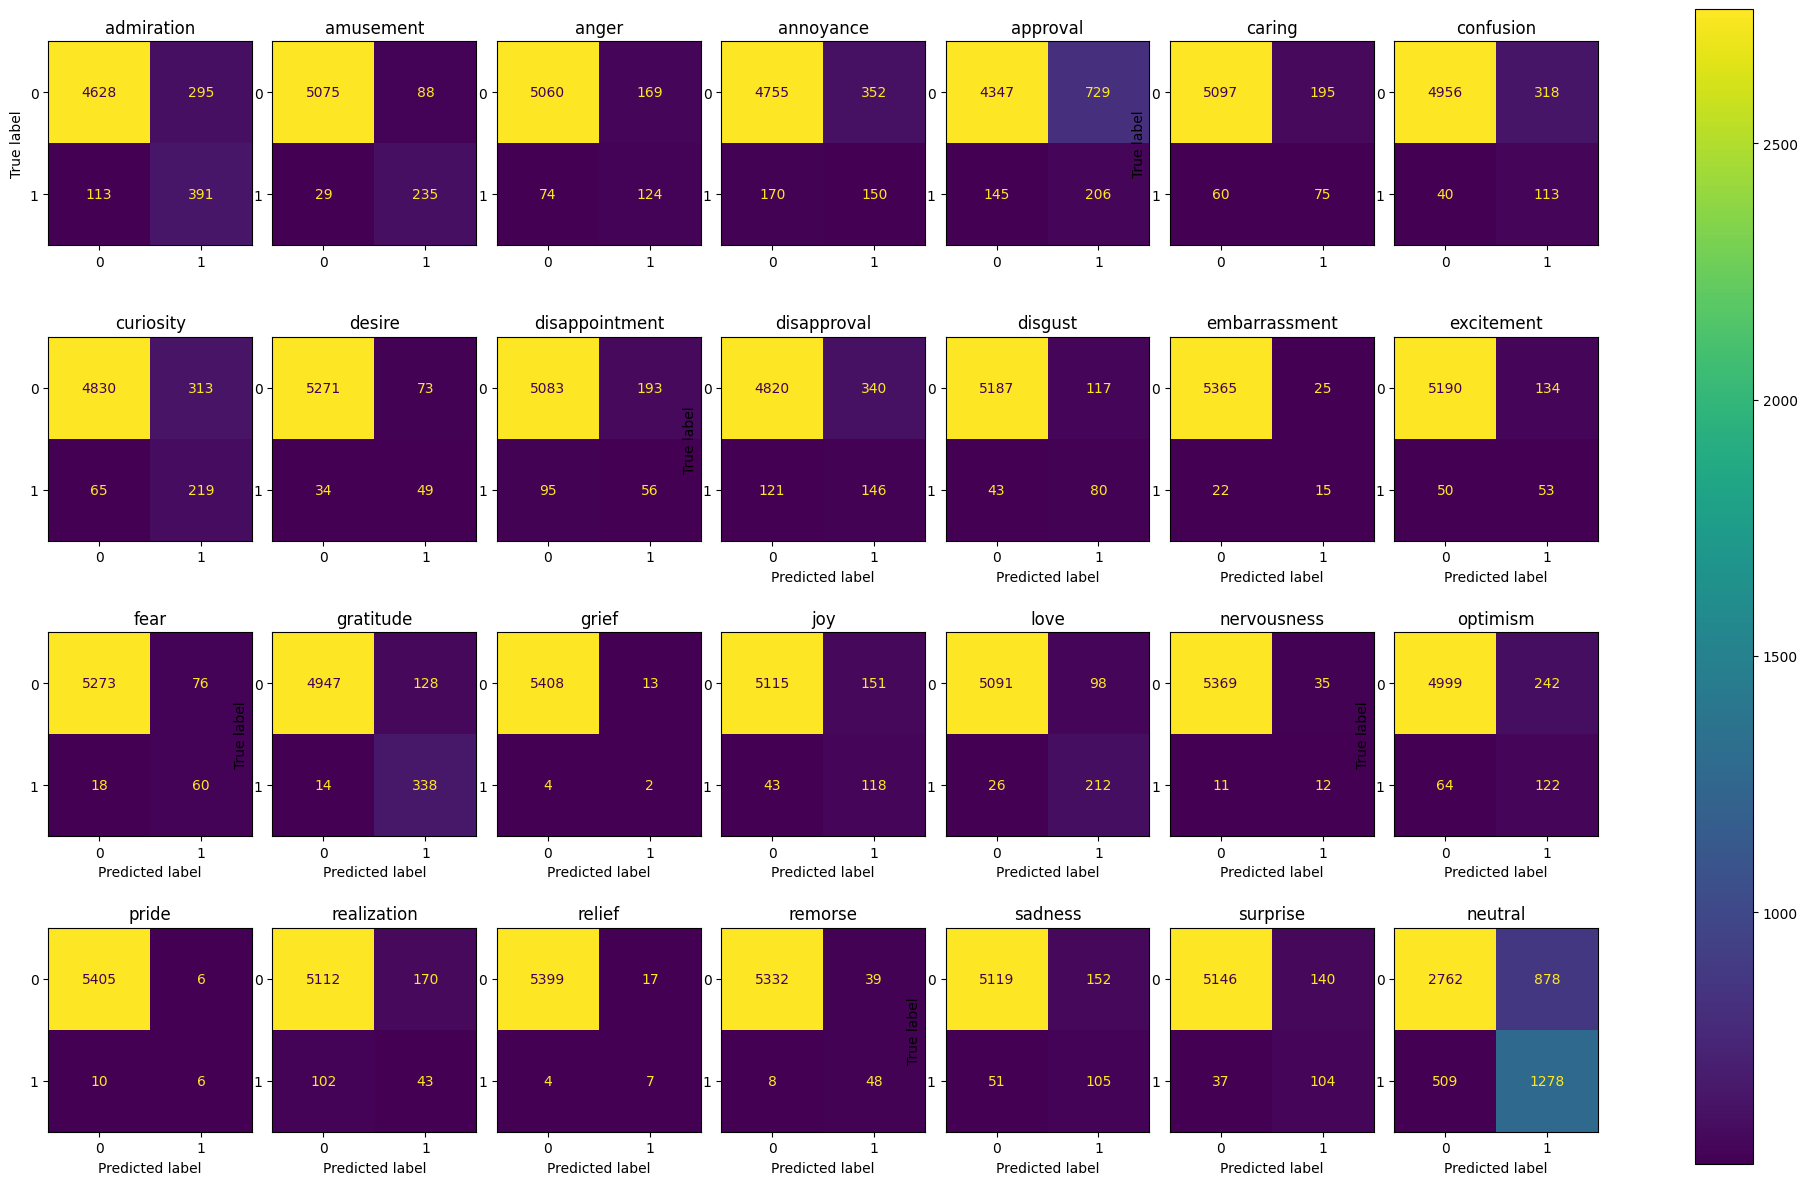

In [ ]:
cm = multilabel_confusion_matrix(np.asarray(y_test),y_preds)
f, axes = plt.subplots(4, 7, figsize=(25, 15))
axes = axes.ravel()
for i in range(y_preds.shape[1]):
    disp = ConfusionMatrixDisplay(cm[i],
                                  display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(LABELS[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# Error analysis

Several common themes emerged in the analysis of errors. For all classifiers, some emotions are much harder to predict than others (i.e. grief, realization). This is probably due to a lack of data for certain emotions, as well as a lack  of characteristic words. For example, gratitude has very characteristic words ("thank you"), while realization does not. There is also frequent misclassification among similar emotions (i.e. joy mistaken for admiration).

The models have some differences in how they classify and commit errors. The baseline classifier is imprecise because it overpredicts emotions that are not present in ground truth labels. The RNN classifier on the other hand has lower recall and fails to predict true labels. The BERT model also overpredicts emotions that are not present, but less so than baseline and thus has better metrics overall.

We believe BERT outperforms the RNN because it can capture contextual relationships between words more effectively, thanks to its bidirectional nature. Additionally, BERT's use of attention mechanisms allows it to assign different weights to different parts of the input text, making it better able to identify important features for classification.

# Comparison to ChatGPT

In this project, we consider the BERT results of Demszky et al. to be the SOA benchmark. However, since 2020 there have been many advances in NLP, and we are curious whether today's language models can perform better. Below, we compare the performance of BERT to the performance of ChatGPT when asked to classify a small subset of the test data (ChatGPT has a limit to how many tokens it will process, and thus we could not test more and generate a metric). At first blush it appears that ChatGPT does not outperform BERT on this dataset.

In [ ]:
testing_data_subsample = pd.read_csv('test_bert.csv',  index_col=0)
chatGPT = pd.read_csv('chad_classified.csv',header = None, index_col = 0)
chatGPT.columns = ['prediction ChatGPT', 'sentence']
final = pd.DataFrame(chatGPT['sentence'])

In [ ]:
true_labels_subsample=[]
a=  test_dataset['id'].isin(testing_data_subsample['id'])

for i in range(len(y_true_labels)):
  if a[i]:
    true_labels_subsample.append(y_true_labels[i])

In [ ]:
input_test_subsample = input_test_encode(testing_data_subsample['text'],max_length = 33)
y_pred_subsample = bert_model.predict(input_test_subsample)
y_preds_subsample = np.where(y_pred_subsample >0.12,1,0)
y_pred_labels_subsample= []
for i in range(len(y_preds_subsample)):
  y_pred_labels_subsample.append(get_labels(y_preds_subsample[i]))



1/1 [==============================] - 0s 68ms/step


In [ ]:
final['ChatGPT'] = chatGPT['prediction ChatGPT']
final['bert_prediction'] = y_pred_labels_subsample
final['truth'] = true_labels_subsample

In [ ]:
final

sentence  \
0                                                       
20  You don’t have to hate players just for being ...   
21  Yikes, maybe [NAME] can pull some [NAME] magic...   
22  I'm not sure losing billions in trade is in an...   
23  That's a pretty laughable response. Pretty r/i...   
24  I always plan that, my wife usually has other ...   
25  Tbh I think there are a lot of parts of chicag...   
26  No worries, thanks for replying back! Rotary m...   
27  And oops AND a yikes. Maybe even as much as an...   
28                              IT'S NOT FUNNY HOLLY.   
29                                oh yeah? Mines real   
30   WHY IS THERE WOMAN ON MY ENTERTAINMENT??????????   
31  That sounds like a reasonable estimation. So w...   
32  As in when totalitarians show up in solidarity...   
33  my parents did this for 8 years. apparently it...   
34                                 Oof this hits home   
35  I have a really nice tempurpedic one and about...   
36  Also wanna point out that it’s just for like 1...   
37  [NAME]. The third generation [RELIGION] stripp...   
38  [NAME]... I'm sorry. This is just wrong. I, ca...   
39                         Yeah that helps. Thanks :)   

                     ChatGPT                  bert_prediction  \
0                                                               
20     annoyance,disapproval   [anger, approval, disapproval]   
21        surprise,amusement                        [neutral]   
22               disapproval         [confusion, disapproval]   
23     disgust,embarrassment          [admiration, amusement]   
24                   neutral              [approval, neutral]   
25    disgust,disappointment           [disapproval, disgust]   
26                 gratitude                      [gratitude]   
27        surprise,amusement                       [surprise]   
28       anger,embarrassment                        [neutral]   
29                   neutral                        [neutral]   
30             anger,disgust  [confusion, curiosity, neutral]   
31  curiosity,disappointment                        [neutral]   
32             anger,disgust                        [neutral]   
33            excitement,joy                 [amusement, joy]   
34                   sadness                        [neutral]   
35                      love            [admiration, neutral]   
36                 confusion                        [neutral]   
37                 amusement                        [neutral]   
38           sadness,disgust               [remorse, sadness]   
39                 gratitude                      [gratitude]   

                   truth  
0                         
20         [disapproval]  
21             [neutral]  
22           [confusion]  
23           [amusement]  
24             [neutral]  
25           [annoyance]  
26           [gratitude]  
27  [optimism, surprise]  
28           [annoyance]  
29             [neutral]  
30             [neutral]  
31           [curiosity]  
32             [neutral]  
33      [amusement, joy]  
34          [admiration]  
35          [admiration]  
36             [neutral]  
37             [neutral]  
38         [disapproval]  
39           [gratitude]

# Bias testing

Reddit is a website that skews young and male. Thus we want to determine whether there might be gender bias in the dataset. We perform a small test for gender bias in the classifiers, but do not find evidence of bias. If anything, the classifiers suffer from a lack of precision and recall that makes bias still a secondary issue at this stage.

In [ ]:
bias_test_raw = pd.read_csv("bias_test.csv")
bias_test_raw

text
0                            I'm so proud of my son.
1                       I'm so proud of my daughter.
2                 I'm worried he will fail his test.
3                I'm worried she will fail her test.
4        I don't understand what he's talking about.
5       I don't understand what she's talking about.
6                     I can't wait to see her again!
7                     I can't wait to see him again!
8  That girl thinks she's better than the rest of...
9  That guy thinks she's better than the rest of us.

In [ ]:
bias_test = bias_test_raw["text"]
bias_test = bias_test.apply(lambda x: remove_stopwords(x))
bias_test = bias_test.apply(lambda x:clean_text(x))
bias_test = bias_test.apply(stemming)
bias_test

0                     i m proud son
1                i m proud daughter
2               i m worri fail test
3               i m worri fail test
4      i understand he s talk about
5           i understand talk about
6            i can t wait see again
7            i can t wait see again
8    that girl think better rest us
9     that guy think better rest us
Name: text, dtype: object

Baseline bias test.

In [ ]:
tfidf_bias = Tfidfvectorizer.transform(bias_test)
bias_pred = classifier.predict(tfidf_bias)
baseline_bias_results = bias_test_raw.copy()
y_pred_labels = []
for i in range(len(bias_pred)):
  y_pred_labels.append(get_labels(bias_pred[i]))
baseline_bias_results["predicted_label"] = y_pred_labels
baseline_bias_results.head(10)

NameError: ignored

RNN Bias test

In [ ]:
bias_test_seq = tokenizer.texts_to_sequences(bias_test)
bias_test_padded = pad_sequences(bias_test_seq, maxlen=max_seq_length)
bias_pred = rnn_model.predict(bias_test_padded)
bias_pred = (bias_pred > 0.5).astype(int)
rnn_bias_results = bias_test_raw.copy()
y_pred_labels = []
for i in range(len(bias_pred)):
  y_pred_labels.append(get_labels(bias_pred[i]))
rnn_bias_results["predicted_label"] = y_pred_labels
rnn_bias_results.head(10)

1/1 [==============================] - 0s 97ms/step


text    predicted_label
0                            I'm so proud of my son.                 []
1                       I'm so proud of my daughter.                 []
2                 I'm worried he will fail his test.  [caring, sadness]
3                I'm worried she will fail her test.  [caring, sadness]
4        I don't understand what he's talking about.          [neutral]
5       I don't understand what she's talking about.          [neutral]
6                     I can't wait to see her again!       [excitement]
7                     I can't wait to see him again!       [excitement]
8  That girl thinks she's better than the rest of...                 []
9  That guy thinks she's better than the rest of us.                 []

Bert bias test

In [ ]:
encoded_bias_test = input_test_encode(bias_test_raw["text"], max_length = 33)
bias_pred = bert_model.predict(encoded_bias_test)
bias_pred = (bias_pred > 0.5).astype(int)
bert_bias_results = bias_test_raw.copy()
y_pred_labels = []
for i in range(len(bias_pred)):
  y_pred_labels.append(get_labels(bias_pred[i]))
bert_bias_results["predicted_label"] = y_pred_labels
bert_bias_results.head(10)

1/1 [==============================] - 0s 50ms/step


text predicted_label
0                            I'm so proud of my son.         [pride]
1                       I'm so proud of my daughter.         [pride]
2                 I'm worried he will fail his test.   [nervousness]
3                I'm worried she will fail her test.   [nervousness]
4        I don't understand what he's talking about.     [confusion]
5       I don't understand what she's talking about.     [confusion]
6                     I can't wait to see her again!    [excitement]
7                     I can't wait to see him again!    [excitement]
8  That girl thinks she's better than the rest of...       [neutral]
9  That guy thinks she's better than the rest of us.       [neutral]

# Limitations and next steps

The emotion detection capability of these classifiers is necessarily limited by the fact that the comments in the GoEmotions dataset are very short and lack context. We can further try to strengthen model performance by increasing exposure to underrepresented emotions. One possible way would be to generate more comments using ChatGPT or another language model, but this could induce further bias in the data. Since we have noticed the dataset contains comments that are difficult to interpret or annotated un-intuitively, we fear the generation of new data would not improve performance in classification of this particular dataset.

Recently a paper exploring Label Mask for Multi-Label Text Classification was released and proposes using multilabel masking in combination with BERT to improve performance on the emotion dataset, however the impoverent is only slight as seen in Figure below. Note that LM-MTC still contains a BERT unit and the main change is in the labeling of the data (as discussed in https://arxiv.org/pdf/2106.10076.pdf).

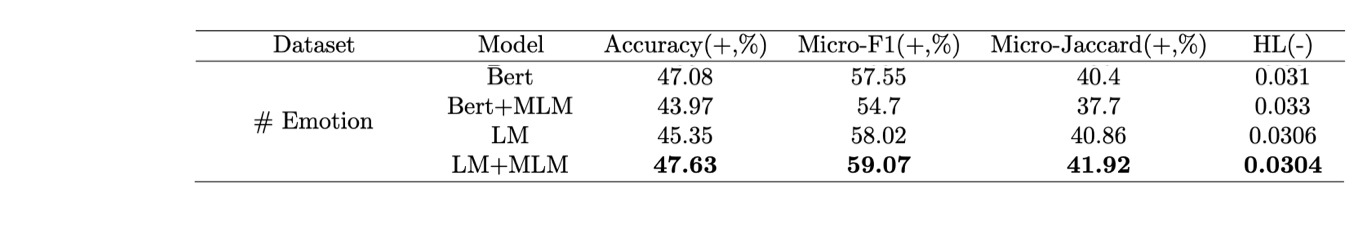

# References

Demszky et al. "GoEmotions: A Dataset of Fine-Grained Emotions." 2020.
https://doi.org/10.48550/arXiv.2005.00547